# Clustering Project Notebook
***

## Zillow: What is driving the errors in the Zestimates?

### Background:

Zillow, a real estate website in the United States, uses a Zestimate to estimate a property's market value.

"The Zestimate® home valuation model is Zillow’s estimate of a home’s market value. A Zestimate incorporates public, MLS and user-submitted data into Zillow’s proprietary formula, also taking into account home facts, location and market trends. It is not an appraisal and can’t be used in place of an appraisal." - zillow.com

For this project, we will look into finding drivers of error in the Zestimate.  Using clustering methodologies, feature identification and comparison, visualizations, statistical testing, and regression models, we are to find drivers of error to predict log error.  


### Project Goals:

- Using Zillow data for single unit/single family homes sold in 2017, find drivers of log error in the Zestimate.

- Create 4 regression models to predict log error

- Use clustering methodologies to help identify drivers of log error

- Deliver findings in a final Jupyter Notebook presentation


## Executive Summary: 

#### Findings Include:


#### Takeaways:


#### Next Steps to Explore Further:

***

# Data Acquisition / Data Preparation / Wrangling

##### Using custom functions in wrangle.py, use an SQl query to pull data from Zillow database joining 7 tables to select only properties sold in 2017 for single unit / single family homes.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

import wrangle_excs as wrangle

# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression

In [2]:
df = wrangle.wrangle_zillow()

### Data Acquisition / Prep / Wrangling Takeaways:

- Created and used functions in wrangle.py to acquire and prep data

- Used a SQL query to join 7 tables
- Selected only single family properties filtered by:
    - Properties with propertylandusetypeid = [261, 262, 263, 264, 265, 266, 279]
    - Only retrieving latest transaction date, eliminating duplicates sold more than once in same year
    - Only selecting properties with at least 1 bath & bed and 350 sqft area 
    - Only properties with a latitude and longitude that is not null
    - Dropping columns that are less than 70% populated, mostly empty columns
    - Adding a 'county' column based on FIPS unique county identifier feature
    - Dropping columns that are not useful features or redundant
    - Filling null values in unitcnt column with 1 since all are single unit properties
    - Replacing nulls with median values for select columns: 
        - 7313 for lotsizesquarefeet
        - 6.0 for buildingqualitytypeid
    -Since this is Southern CA, filling null with 'None' for heatingorsystemdesc because most likely don't have one
    -Rename columns for easier readability
    -Removed outliers based on Inter Quartile Rule for properties with outliers in square footage, price, bedrooms, and bathrooms
    



# Explore

In [3]:
# Take a look at the dataframe returned from acquire & prep after wrangling
df.shape

(67490, 26)

In [4]:
df.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips    latitude  \
0        3.5       4.0                    6.0      3100.0  6059.0  33634931.0   
1        1.0       2.0                    6.0      1465.0  6111.0  34449266.0   
2        2.0       3.0                    6.0      1243.0  6059.0  33886168.0   
3        3.0       4.0                    8.0      2376.0  6037.0  34245180.0   
4        3.0       3.0                    8.0      1312.0  6037.0  34185120.0   

     longitude  lotsizesquarefeet  propertylandusetypeid  \
0 -117869207.0             4506.0                  261.0   
1 -119281531.0            12647.0                  261.0   
2 -117823170.0             8432.0                  261.0   
3 -118240722.0            13038.0                  261.0   
4 -118414640.0           278581.0                  266.0   

   rawcensustractandblock  ...  structuretaxvaluedollarcnt  tax_value  \
0            6.059063e+07  ...                    485713.0  1023282.0   
1            6.111001e+07  ...                     88000.0   464000.0   
2            6.059022e+07  ...                     85289.0   564778.0   
3            6.037300e+07  ...                    108918.0   145143.0   
4            6.037124e+07  ...                     73681.0   119407.0   

   assessmentyear  landtaxvaluedollarcnt  taxamount  logerror  \
0          2016.0               537569.0   11013.72  0.025595   
1          2016.0               376000.0    5672.48  0.055619   
2          2016.0               479489.0    6488.30  0.005383   
3          2016.0                36225.0    1777.51 -0.103410   
4          2016.0                45726.0    1533.89  0.006940   

   transactiondate  heatingorsystemdesc        propertylandusedesc  \
0       2017-01-01                 None  Single Family Residential   
1       2017-01-01                 None  Single Family Residential   
2       2017-01-01                 None  Single Family Residential   
3       2017-01-01              Central  Single Family Residential   
4       2017-01-01              Central                Condominium   

        county  
0       Orange  
1      Ventura  
2       Orange  
3  Los Angeles  
4  Los Angeles  

[5 rows x 26 columns]

In [5]:
#Check to see if nulls were removed
wrangle.nulls_by_col(df)

num_rows_missing  percent_rows_missing
bathrooms                                  0                   0.0
bedrooms                                   0                   0.0
buildingqualitytypeid                      0                   0.0
sq_footage                                 0                   0.0
fips                                       0                   0.0
latitude                                   0                   0.0
longitude                                  0                   0.0
lotsizesquarefeet                          0                   0.0
propertylandusetypeid                      0                   0.0
rawcensustractandblock                     0                   0.0
regionidcity                               0                   0.0
regionidcounty                             0                   0.0
regionidzip                                0                   0.0
roomcnt                                    0                   0.0
unitcnt                                    0                   0.0
yr_built                                   0                   0.0
structuretaxvaluedollarcnt                 0                   0.0
tax_value                                  0                   0.0
assessmentyear                             0                   0.0
landtaxvaluedollarcnt                      0                   0.0
taxamount                                  0                   0.0
logerror                                   0                   0.0
transactiondate                            0                   0.0
heatingorsystemdesc                        0                   0.0
propertylandusedesc                        0                   0.0
county                                     0                   0.0

In [6]:
wrangle.nulls_by_row(df)

num_cols_missing percent_cols_missing  index
0                0                  0.0  67490

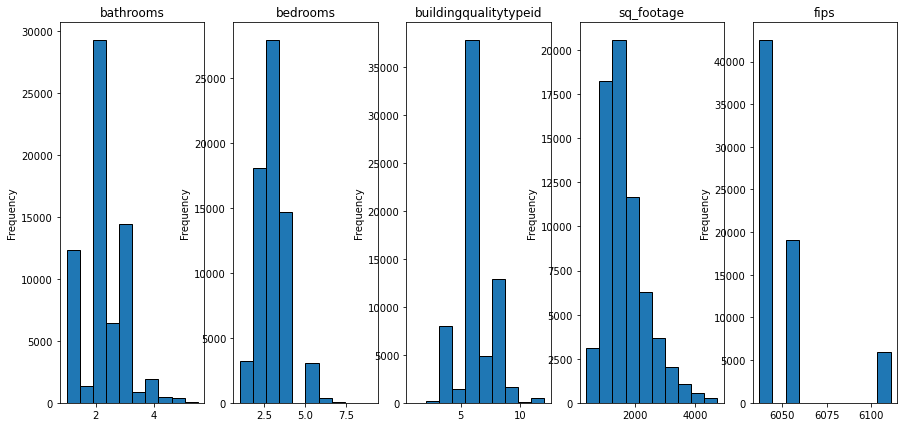

In [7]:
# Plot the distribution of some numeric variables
fig, axs = plt.subplots(1, 5, figsize=(15, 7))

for ax, col in zip(axs, df.select_dtypes('number')):
    df[col].plot.hist(ax=ax, title=col, ec='black')

In [8]:
#Binning square footage for comparison and visualization purposes
df['sq_footage_bins'] = pd.cut(df.sq_footage, [0, 1000, 2000,3000,4000, 10000])
df.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips    latitude  \
0        3.5       4.0                    6.0      3100.0  6059.0  33634931.0   
1        1.0       2.0                    6.0      1465.0  6111.0  34449266.0   
2        2.0       3.0                    6.0      1243.0  6059.0  33886168.0   
3        3.0       4.0                    8.0      2376.0  6037.0  34245180.0   
4        3.0       3.0                    8.0      1312.0  6037.0  34185120.0   

     longitude  lotsizesquarefeet  propertylandusetypeid  \
0 -117869207.0             4506.0                  261.0   
1 -119281531.0            12647.0                  261.0   
2 -117823170.0             8432.0                  261.0   
3 -118240722.0            13038.0                  261.0   
4 -118414640.0           278581.0                  266.0   

   rawcensustractandblock  ...  tax_value  assessmentyear  \
0            6.059063e+07  ...  1023282.0          2016.0   
1            6.111001e+07  ...   464000.0          2016.0   
2            6.059022e+07  ...   564778.0          2016.0   
3            6.037300e+07  ...   145143.0          2016.0   
4            6.037124e+07  ...   119407.0          2016.0   

   landtaxvaluedollarcnt  taxamount  logerror  transactiondate  \
0               537569.0   11013.72  0.025595       2017-01-01   
1               376000.0    5672.48  0.055619       2017-01-01   
2               479489.0    6488.30  0.005383       2017-01-01   
3                36225.0    1777.51 -0.103410       2017-01-01   
4                45726.0    1533.89  0.006940       2017-01-01   

   heatingorsystemdesc        propertylandusedesc       county  \
0                 None  Single Family Residential       Orange   
1                 None  Single Family Residential      Ventura   
2                 None  Single Family Residential       Orange   
3              Central  Single Family Residential  Los Angeles   
4              Central                Condominium  Los Angeles   

   sq_footage_bins  
0     (3000, 4000]  
1     (1000, 2000]  
2     (1000, 2000]  
3     (2000, 3000]  
4     (1000, 2000]  

[5 rows x 27 columns]

In [9]:
df['transactiondate'] = pd.to_datetime(df['transactiondate'])
df['month'] = pd.DatetimeIndex(df['transactiondate']).month
df.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips    latitude  \
0        3.5       4.0                    6.0      3100.0  6059.0  33634931.0   
1        1.0       2.0                    6.0      1465.0  6111.0  34449266.0   
2        2.0       3.0                    6.0      1243.0  6059.0  33886168.0   
3        3.0       4.0                    8.0      2376.0  6037.0  34245180.0   
4        3.0       3.0                    8.0      1312.0  6037.0  34185120.0   

     longitude  lotsizesquarefeet  propertylandusetypeid  \
0 -117869207.0             4506.0                  261.0   
1 -119281531.0            12647.0                  261.0   
2 -117823170.0             8432.0                  261.0   
3 -118240722.0            13038.0                  261.0   
4 -118414640.0           278581.0                  266.0   

   rawcensustractandblock  ...  assessmentyear  landtaxvaluedollarcnt  \
0            6.059063e+07  ...          2016.0               537569.0   
1            6.111001e+07  ...          2016.0               376000.0   
2            6.059022e+07  ...          2016.0               479489.0   
3            6.037300e+07  ...          2016.0                36225.0   
4            6.037124e+07  ...          2016.0                45726.0   

   taxamount  logerror  transactiondate  heatingorsystemdesc  \
0   11013.72  0.025595       2017-01-01                 None   
1    5672.48  0.055619       2017-01-01                 None   
2    6488.30  0.005383       2017-01-01                 None   
3    1777.51 -0.103410       2017-01-01              Central   
4    1533.89  0.006940       2017-01-01              Central   

         propertylandusedesc       county  sq_footage_bins  month  
0  Single Family Residential       Orange     (3000, 4000]      1  
1  Single Family Residential      Ventura     (1000, 2000]      1  
2  Single Family Residential       Orange     (1000, 2000]      1  
3  Single Family Residential  Los Angeles     (2000, 3000]      1  
4                Condominium  Los Angeles     (1000, 2000]      1  

[5 rows x 28 columns]

In [10]:
#Binning transactiondate for comparison and visualization purposes
df['month_bins'] = pd.cut(df.month, [0,3,6,9,12])
df.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips    latitude  \
0        3.5       4.0                    6.0      3100.0  6059.0  33634931.0   
1        1.0       2.0                    6.0      1465.0  6111.0  34449266.0   
2        2.0       3.0                    6.0      1243.0  6059.0  33886168.0   
3        3.0       4.0                    8.0      2376.0  6037.0  34245180.0   
4        3.0       3.0                    8.0      1312.0  6037.0  34185120.0   

     longitude  lotsizesquarefeet  propertylandusetypeid  \
0 -117869207.0             4506.0                  261.0   
1 -119281531.0            12647.0                  261.0   
2 -117823170.0             8432.0                  261.0   
3 -118240722.0            13038.0                  261.0   
4 -118414640.0           278581.0                  266.0   

   rawcensustractandblock  ...  landtaxvaluedollarcnt  taxamount  logerror  \
0            6.059063e+07  ...               537569.0   11013.72  0.025595   
1            6.111001e+07  ...               376000.0    5672.48  0.055619   
2            6.059022e+07  ...               479489.0    6488.30  0.005383   
3            6.037300e+07  ...                36225.0    1777.51 -0.103410   
4            6.037124e+07  ...                45726.0    1533.89  0.006940   

   transactiondate  heatingorsystemdesc        propertylandusedesc  \
0       2017-01-01                 None  Single Family Residential   
1       2017-01-01                 None  Single Family Residential   
2       2017-01-01                 None  Single Family Residential   
3       2017-01-01              Central  Single Family Residential   
4       2017-01-01              Central                Condominium   

        county  sq_footage_bins  month  month_bins  
0       Orange     (3000, 4000]      1      (0, 3]  
1      Ventura     (1000, 2000]      1      (0, 3]  
2       Orange     (1000, 2000]      1      (0, 3]  
3  Los Angeles     (2000, 3000]      1      (0, 3]  
4  Los Angeles     (1000, 2000]      1      (0, 3]  

[5 rows x 29 columns]

(-4.0, 4.0)

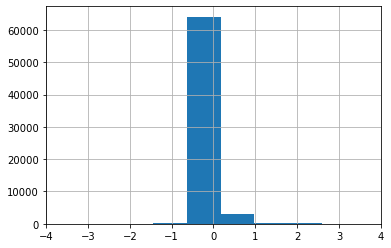

In [11]:
#Look at logerror
df.logerror.hist()
plt.xlim(-4, 4)

In [12]:
df.logerror.max(), df.logerror.min(), df.logerror.mean(), df.logerror.median()

(3.39454406516, -4.65542037764, 0.016190522976922635, 0.00618658543751)

In [13]:
df.buildingqualitytypeid.value_counts()

6.0     37816
8.0     12896
4.0      8063
7.0      4905
9.0      1605
5.0      1468
11.0      479
3.0       142
10.0       80
12.0       28
1.0         5
2.0         3
Name: buildingqualitytypeid, dtype: int64

### Before exploring data further, will need to split data into train, validate and test so that we only explore on train.

In [14]:
train, validate, test = wrangle.train_validate_test_split(df)
train.shape, validate.shape, test.shape

((40494, 29), (13498, 29), (13498, 29))

### Question 1.  Does log error differ across square feet?

<AxesSubplot:title={'center':'Is there a relationship between logerror and square feet?'}, xlabel='logerror', ylabel='sq_footage'>

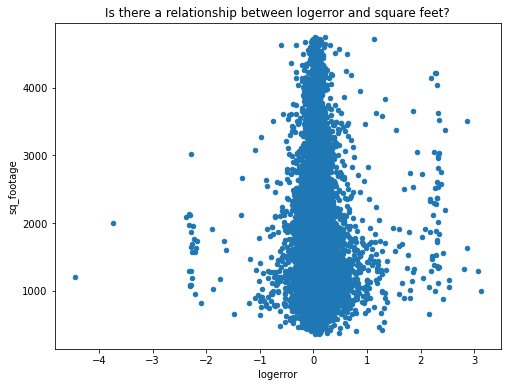

In [15]:
#Let's look at the relationship between log error and square feet
train.plot.scatter(
    x="logerror",
    y="sq_footage",
    title='Is there a relationship between logerror and square feet?',
    figsize=(8, 6),
)

<AxesSubplot:>

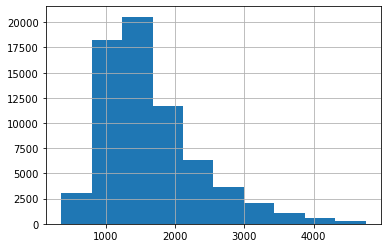

In [16]:
#Let's look at the distribution of square footage 
df.sq_footage.hist()

<AxesSubplot:title={'center':'Distribution of sq_footage_bin'}>

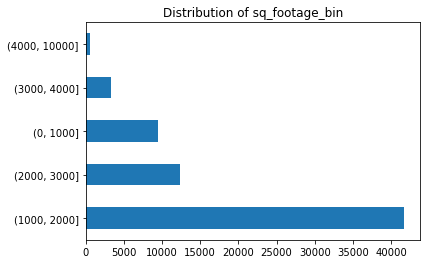

In [17]:
#Let's look at the distribution of square footage by bins
#Looks like most properties are between 1,000-2,000 square feet

df.sq_footage_bins.value_counts().plot.barh(title='Distribution of sq_footage_bin')

<AxesSubplot:xlabel='sq_footage_bins', ylabel='logerror'>

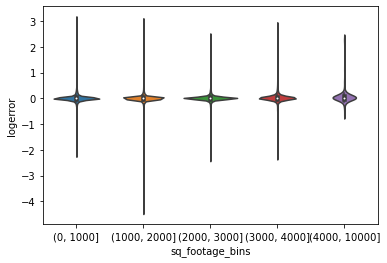

In [18]:
#Let's look at how log error compares across square footage by bins
#It doesn't look like there's much difference 
sns.violinplot(data=train, y='logerror', x='sq_footage_bins')

### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance between the square footage

$H_a$: there is a difference in logerror variance between the square footage

In [19]:
stats.levene(
    train[train.sq_footage <= 1000].logerror,
    train[train.sq_footage > 1000].logerror,
)

LeveneResult(statistic=26.421381823118583, pvalue=2.7575885155652377e-07)

In [20]:
stats.levene(
    train[train.sq_footage <= 2000].logerror,
    train[train.sq_footage > 2000].logerror,
)

LeveneResult(statistic=0.9133570477417297, pvalue=0.339230966900938)

In [21]:
stats.levene(
    train[train.sq_footage <= 3000].logerror,
    train[train.sq_footage > 3000].logerror,
)

LeveneResult(statistic=33.21175253136165, pvalue=8.32476642871702e-09)

In [22]:
stats.levene(
    train[train.sq_footage <= 4000].logerror,
    train[train.sq_footage > 4000].logerror,
)

LeveneResult(statistic=26.208966386291532, pvalue=3.077963100113169e-07)

#### Conclusion:
We reject the null hypothesis that the variance in logerror is the same for all square footages.
The variance is not equal.

### Create independent statistical tests to check for dependency amongst variables

In [23]:
stats.ttest_ind(
    train[train.sq_footage <= 1000].logerror,
    train[train.sq_footage > 1000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-1.1795354395250444, pvalue=0.23822231653253545)

In [24]:
stats.ttest_ind(
    train[train.sq_footage <= 2000].logerror,
    train[train.sq_footage > 2000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-5.468852786673966, pvalue=4.6028033991275334e-08)

In [25]:
stats.ttest_ind(
    train[train.sq_footage <= 3000].logerror,
    train[train.sq_footage > 3000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-5.288640220586799, pvalue=1.3446342217119166e-07)

In [26]:
stats.ttest_ind(
    train[train.sq_footage <= 4000].logerror,
    train[train.sq_footage > 4000].logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-3.2396298227168385, pvalue=0.0013143037052781863)

### Conclusion:
We reject the null hypothesis that the logerror is the same for square footages above 1000 square feet.

### Question 2. Does  log error differ across county?

In [27]:
#Look at how counties compare in number
df.county.value_counts()

Los Angeles    42474
Orange         19108
Ventura         5908
Name: county, dtype: int64

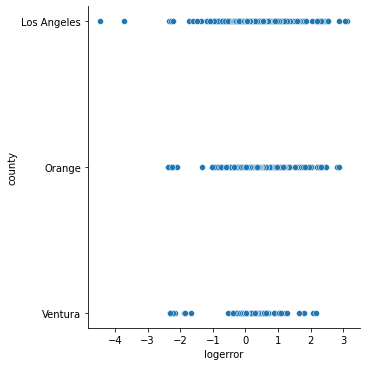

In [28]:
#Look at how log error compares amongst counties
sns.relplot(data=train, x='logerror', y='county')

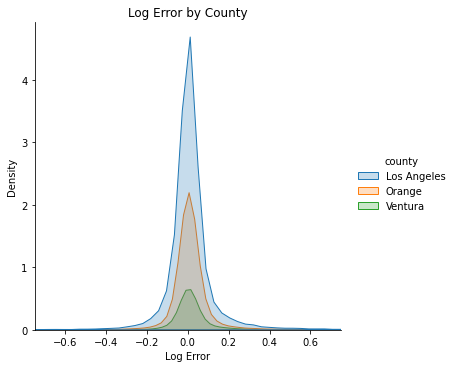

In [29]:
#Plotting distribution of log error by county

sns.displot(train, x='logerror', hue='county', kind='kde', fill=True)
plt.title('Log Error by County')
plt.xlabel('Log Error')
plt.xlim(-0.75, 0.75)
plt.show()

#### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance between the counties
 
𝐻𝑎 : there is a difference in logerror variance between the counties

In [30]:
stats.levene(
    train[train.county == 'Los Angeles'].logerror,
    train[train.county != 'Los Angeles'].logerror,
)

LeveneResult(statistic=25.420357603593807, pvalue=4.630126029827358e-07)

In [31]:
stats.levene(
    train[train.county == 'Ventura'].logerror,
    train[train.county != 'Ventura'].logerror,
)

LeveneResult(statistic=13.435255590635176, pvalue=0.0002472547032054955)

In [32]:
stats.levene(
    train[train.county == 'Orange'].logerror,
    train[train.county != 'Orange'].logerror,
)

LeveneResult(statistic=9.66021727850087, pvalue=0.0018843171405163632)

### Conclusion:
We reject the null hypothesis that the variance in logerror is the same for all counties.
The variance is not equal.

In [33]:
#Running a T-Test to check if county is independent of log error
stats.ttest_ind(
    df.query('county == "Los Angeles"').logerror,
    df.query('county == "Orange"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-3.690124587002322, pvalue=0.0002245156221965261)

In [34]:
stats.ttest_ind(
    df.query('county == "Ventura"').logerror,
    df.query('county == "Orange"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-2.0580613382754938, pvalue=0.03960587164470629)

In [35]:
stats.ttest_ind(
    df.query('county == "Los Angeles"').logerror,
    df.query('county == "Ventura"').logerror,
    equal_var=False,
)

Ttest_indResult(statistic=-0.38916233430025177, pvalue=0.6971666541218813)

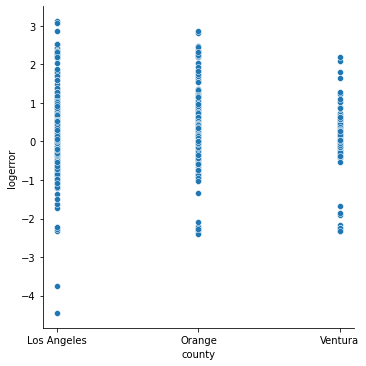

In [36]:
sns.relplot(data=train, y='logerror', x='county')

### Conclusion:
We reject the null hypothesis that the logerror is the same for all counties.

### Question 3. Does  log error differ across transaction date?

<AxesSubplot:title={'center':'Is there a relationship between logerror and transaction date?'}, xlabel='transactiondate', ylabel='logerror'>

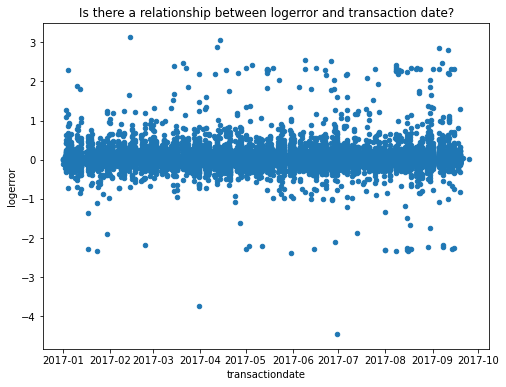

In [37]:
train.plot.scatter(
    y="logerror",
    x="transactiondate",
    title='Is there a relationship between logerror and transaction date?',
    figsize=(8, 6),
)

<AxesSubplot:>

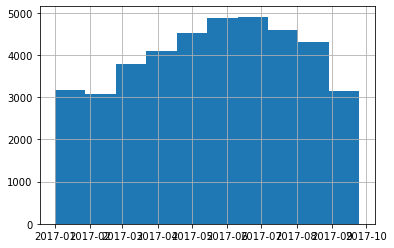

In [38]:
train.transactiondate.hist()

In [39]:
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
train['month'] = pd.DatetimeIndex(train['transactiondate']).month
train.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips  \
6378         1.0       3.0                    4.0      1368.0  6037.0   
65133        2.0       4.0                    8.0      2381.0  6037.0   
45602        2.0       3.0                    6.0      1810.0  6037.0   
75623        2.0       4.0                    6.0      1558.0  6059.0   
71792        2.0       4.0                    6.0      1769.0  6111.0   

         latitude    longitude  lotsizesquarefeet  propertylandusetypeid  \
6378   34174813.0 -118512540.0             5899.0                  261.0   
65133  34536607.0 -118049605.0            39349.0                  261.0   
45602  33824560.0 -118270268.0             5604.0                  261.0   
75623  33791770.0 -118068568.0             8255.0                  261.0   
71792  34265339.0 -118798087.0             8090.0                  261.0   

       rawcensustractandblock  ...  landtaxvaluedollarcnt  taxamount  \
6378             6.037139e+07  ...               414357.0    6417.40   
65133            6.037911e+07  ...               122000.0    4191.95   
45602            6.037544e+07  ...               383000.0    6349.38   
75623            6.059110e+07  ...                30142.0    1235.08   
71792            6.111008e+07  ...               359000.0    6301.48   

       logerror  transactiondate  heatingorsystemdesc  \
6378   0.211513       2017-01-30           Floor/Wall   
65133  0.018574       2017-08-10              Central   
45602  0.017428       2017-06-13           Floor/Wall   
75623  0.037663       2017-09-12                 None   
71792  0.029618       2017-08-30                 None   

             propertylandusedesc       county  sq_footage_bins  month  \
6378   Single Family Residential  Los Angeles     (1000, 2000]      1   
65133  Single Family Residential  Los Angeles     (2000, 3000]      8   
45602  Single Family Residential  Los Angeles     (1000, 2000]      6   
75623  Single Family Residential       Orange     (1000, 2000]      9   
71792  Single Family Residential      Ventura     (1000, 2000]      8   

       month_bins  
6378       (0, 3]  
65133      (6, 9]  
45602      (3, 6]  
75623      (6, 9]  
71792      (6, 9]  

[5 rows x 29 columns]

<AxesSubplot:title={'center':'Distribution of month_bin'}>

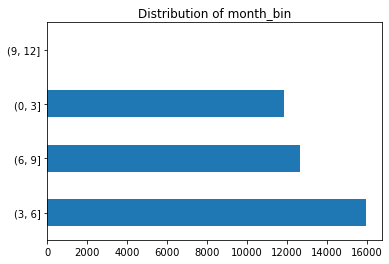

In [40]:
train.month_bins.value_counts().plot.barh(title='Distribution of month_bin')

<AxesSubplot:xlabel='month_bins', ylabel='logerror'>

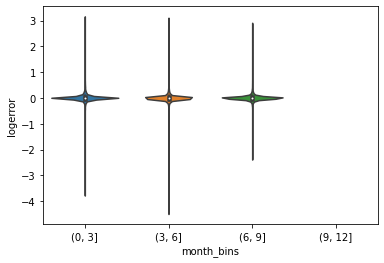

In [41]:
sns.violinplot(data=train, y='logerror', x='month_bins')

<AxesSubplot:title={'center':'Is there a relationship between logerror and month?'}, xlabel='month', ylabel='logerror'>

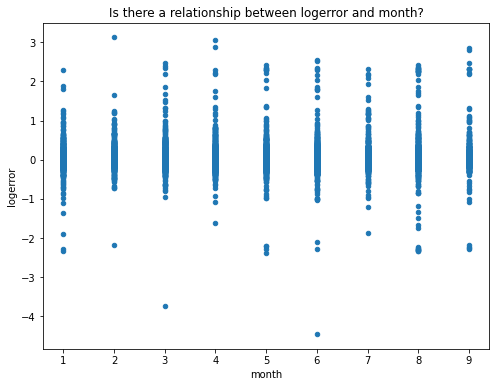

In [42]:
train.plot.scatter(
    y="logerror",
    x="month",
    title='Is there a relationship between logerror and month?',
    figsize=(8, 6),
)

### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance between the transaction months before and after June

$H_a$: there is a difference in logerror variance between the transaction months before and after June

In [43]:
stats.levene(
    train[train.month <= 6].logerror,
    train[train.month > 6].logerror,
)

LeveneResult(statistic=0.23020178079501571, pvalue=0.6313768429384812)

In [44]:
# We fail to reject the null hypothesis that there is no difference in logerror variance between the 
#transaction months before and after June.  The variance is equal. 

### Are the log error and the month of the transaction independent of each other?

$H_0$ : The log error for sales in or before June is the same that logerror for sales after June.

$H_a$ : The log error for sales in or before June is the not same that logerror for sales after June.

In [45]:
stats.ttest_ind(
   train[train.month <= 6].logerror,
    train[train.month > 6].logerror,
    equal_var=True,
)

Ttest_indResult(statistic=-2.7771286250995333, pvalue=0.005486668073244086)

### Conclusion:
We reject the null hypothesis that the log error for sales in or before June is the same that log error for sales after June. The logerror for sales in or before June is the same that logerror for sales after June.

### Question 4.  If we control for month, does log error differ across county?
1. Viz logerror by county for each month bin

2. Analyze each month bin separately

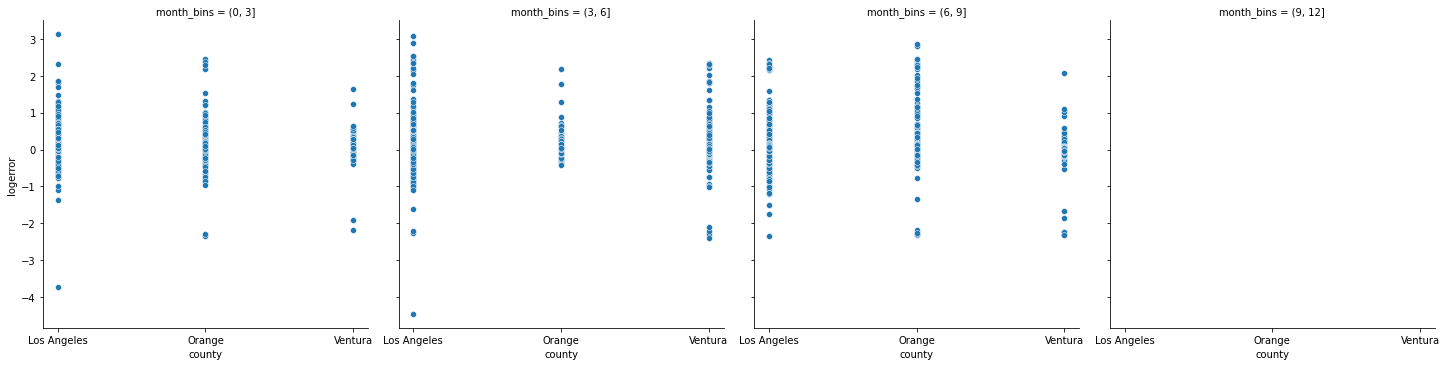

In [46]:
sns.relplot(data=train, y='logerror', x='county', col='month_bins')

In [47]:
# Logerror does not seem to vary much by month or county

Text(0.5, 1.0, 'Does county acccount for upper vs lower\nlogerror in square footage for sales before July?')

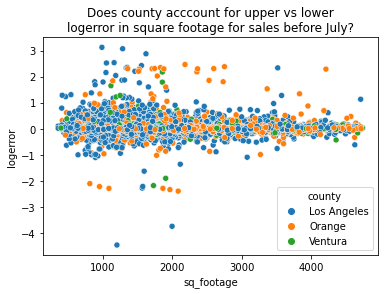

In [48]:
sns.scatterplot(
    x='sq_footage',
    y='logerror',
    data=train[train.month <= 6],
    hue='county',
)
plt.title("Does county acccount for upper vs lower\nlogerror in square footage for sales before July?")

In [49]:
# For sales before July 1st, log error may be grouped by county where Orange County and LA County have higher errors.

Text(0.5, 1.0, 'Does county account for upper vs lower\n logerror in the square footage?')

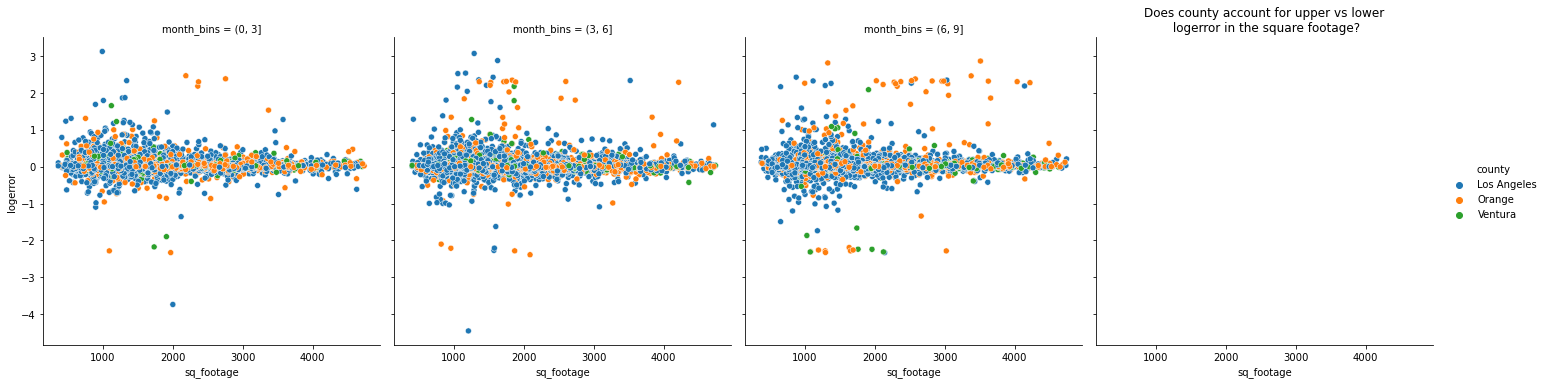

In [50]:
sns.relplot(
    x='sq_footage',
    y='logerror',
    data=train,
    hue='county',
    col='month_bins',
)
plt.title("Does county account for upper vs lower\n logerror in the square footage?")

In [51]:
# Orange County seems to have higher log errors compared to the other counties, 
#especially during the months of June-Sept.  Los Angeles couny looks to have more variance in error, being more 
#scattered on both sides of 0. 


Text(0.5, 1.0, 'Does county account for upper vs lower\n logerror in the square footage?')

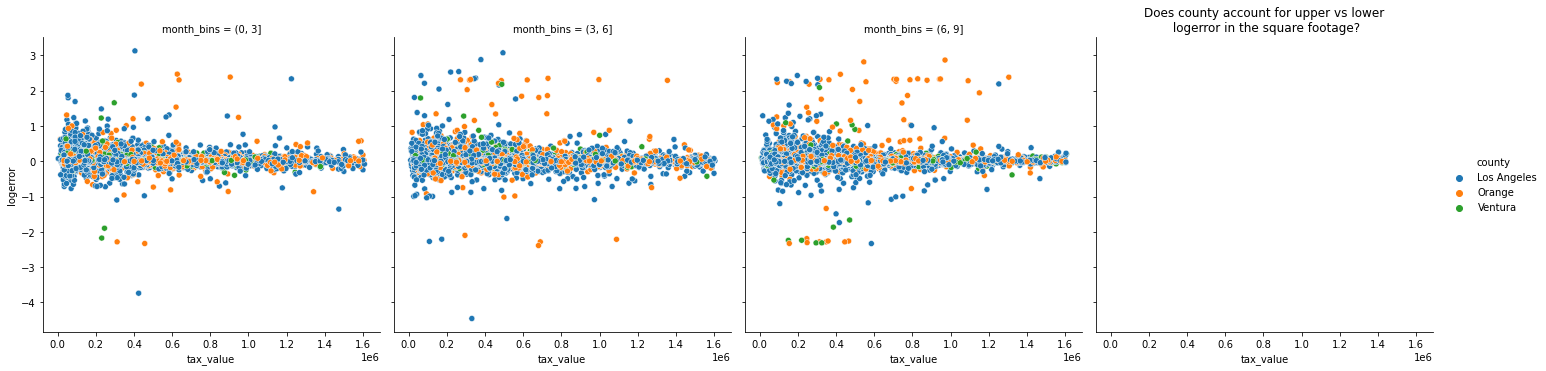

In [52]:
sns.relplot(
    x='tax_value',
    y='logerror',
    data=train,
    hue='county',
    col='month_bins',
)
plt.title("Does county account for upper vs lower\n logerror in the square footage?")

In [53]:
#Comparing using tax value, Orange County still seems to have the highest log errors, especially during June-Sept

Text(0.5, 1.0, 'Does county account for upper vs lower\n log error in the price of property?')

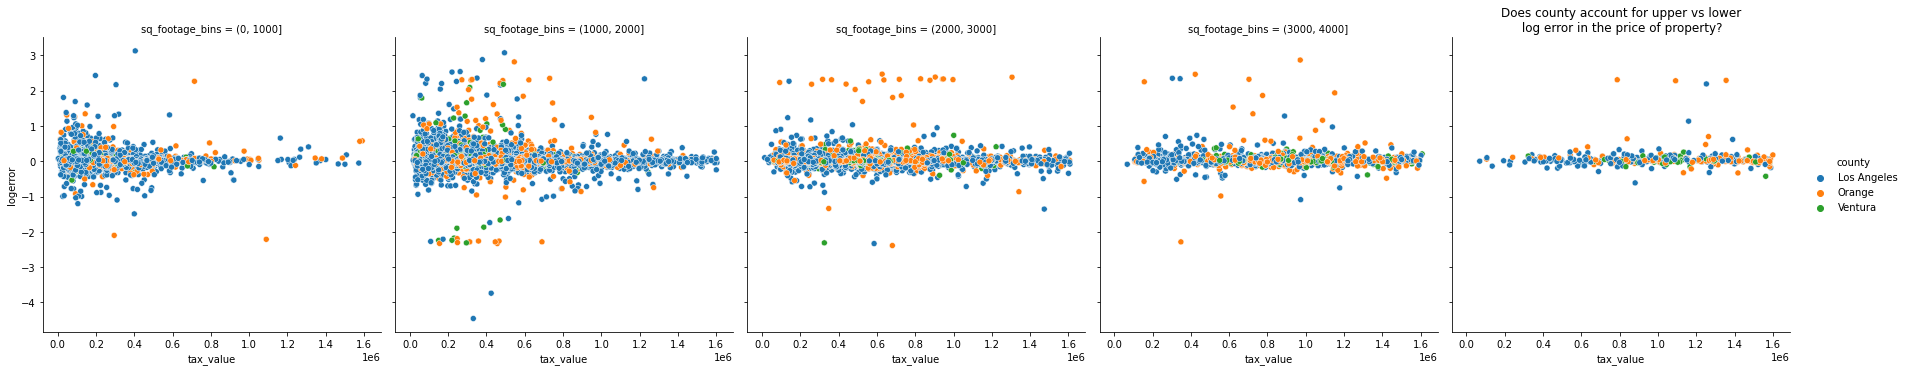

In [54]:
sns.relplot(
    x='tax_value',
    y='logerror',
    data=train,
    hue='county',
    col='sq_footage_bins',
)

plt.title("Does county account for upper vs lower\n log error in the price of property?")

In [55]:
#Comparing using tax value, Orange County accounts for most of the upper band seen in the log error (higher log error)
# especially for homes between 2,000-3,000 square feet.

In [56]:
# Overall, county does seem to be grouped together for certain months and certain square footage

In [57]:
#Let's look at how variables are correlated
corr =  train.corr(method='pearson')

<AxesSubplot:>

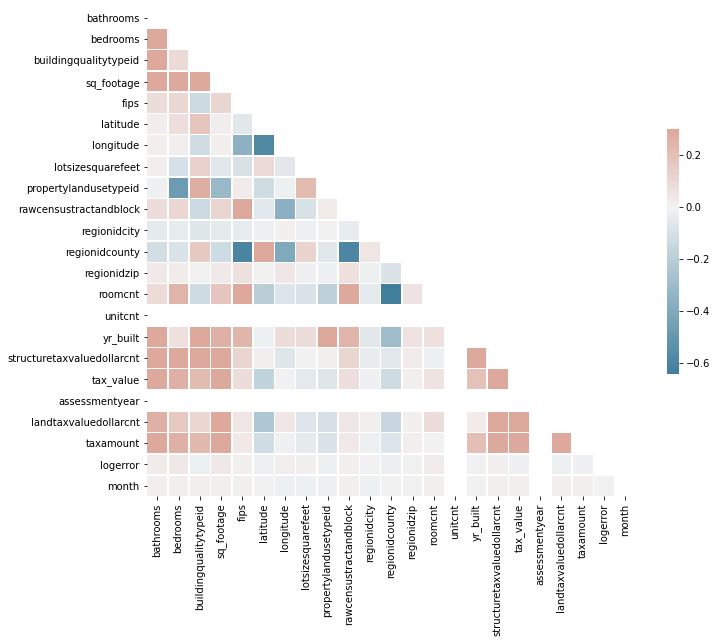

In [58]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [59]:
corr_log = train.corrwith(train["logerror"])
corr_log.max

<bound method NDFrame._add_numeric_operations.<locals>.max of bathrooms                     0.027558
bedrooms                      0.035392
buildingqualitytypeid        -0.013531
sq_footage                    0.036798
fips                          0.006574
latitude                     -0.011984
longitude                     0.015879
lotsizesquarefeet             0.007544
propertylandusetypeid        -0.013906
rawcensustractandblock        0.006598
regionidcity                 -0.002021
regionidcounty               -0.017465
regionidzip                   0.002730
roomcnt                       0.020787
unitcnt                            NaN
yr_built                      0.004309
structuretaxvaluedollarcnt    0.006424
tax_value                    -0.006590
assessmentyear                     NaN
landtaxvaluedollarcnt        -0.012332
taxamount                    -0.007145
logerror                      1.000000
month                         0.001169
dtype: float64>

In [60]:
print(corr_log.sort_values(ascending=False))

logerror                      1.000000
sq_footage                    0.036798
bedrooms                      0.035392
bathrooms                     0.027558
roomcnt                       0.020787
longitude                     0.015879
lotsizesquarefeet             0.007544
rawcensustractandblock        0.006598
fips                          0.006574
structuretaxvaluedollarcnt    0.006424
yr_built                      0.004309
regionidzip                   0.002730
month                         0.001169
regionidcity                 -0.002021
tax_value                    -0.006590
taxamount                    -0.007145
latitude                     -0.011984
landtaxvaluedollarcnt        -0.012332
buildingqualitytypeid        -0.013531
propertylandusetypeid        -0.013906
regionidcounty               -0.017465
unitcnt                            NaN
assessmentyear                     NaN
dtype: float64


In [61]:
#When looking at correlation with log error, square footage, bedrooms, and bathrooms rank highest.

### Question 5: Does log error differ for different number of bedrooms?

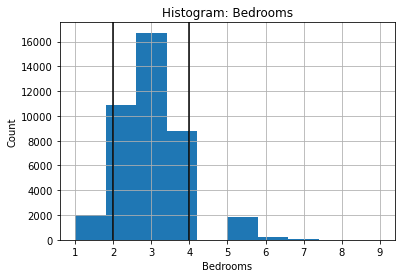

In [62]:
ax = train.bedrooms.hist()
plt.title('Histogram: Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
ax.axvline(2, color='black')
ax.axvline(4, color='black')



<AxesSubplot:title={'center':'Is there a relationship between log error and bedrooms?'}, xlabel='bedrooms', ylabel='logerror'>

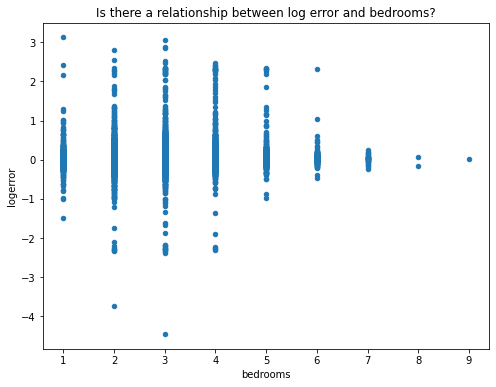

In [63]:
train.plot.scatter(
    y="logerror",
    x="bedrooms",
    title='Is there a relationship between log error and bedrooms?',
    figsize=(8, 6),
)

<AxesSubplot:xlabel='bedrooms', ylabel='logerror'>

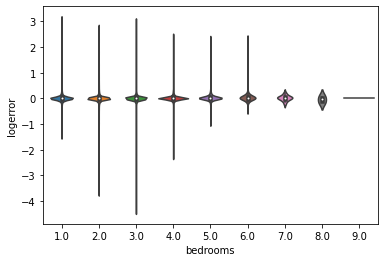

In [64]:
sns.violinplot(data=train, y='logerror', x='bedrooms')

### Levene's Test: test for equal variance
$H_0$: there is no difference in logerror variance for different number of bedrooms

$H_a$: there is a difference in logerror variance different number of bedrooms

In [65]:
stats.levene(
    train[train.bedrooms <= 5].logerror,
    train[train.month > 5].logerror,
)

LeveneResult(statistic=0.052954660926955895, pvalue=0.8180002577359538)

In [66]:
# We fail to reject the null hypothesis that there is no difference in logerror variance for different number of bedrooms.
#The variance is equal

### Is the log error the same for properties with  4 or less as those with more than 4 bedrooms?

$H_0$ : The logerror is the same for properties with 4 bedrooms or less as with those with more than 4 bedrooms.

$H_a$ : The logerror is not the same for properties with 4 bedrooms or less as with those with more than 4 bedrooms.

In [67]:
stats.ttest_ind(
   train[train.bedrooms <= 4].logerror,
    train[train.bedrooms > 4].logerror,
    equal_var=True,
)

Ttest_indResult(statistic=-6.256198579620443, pvalue=3.984111118952614e-10)

### Conclusion:
We reject the null hypothesis that the log error is the same for properties with 4 bedrooms or less compared to those with more than 4 bedrooms. The log error is not the same for properties with 4 bedrooms or less compared to those with more than  bedrooms.

Text(0.5, 1.0, 'Does log error depend on number of bedrooms?')

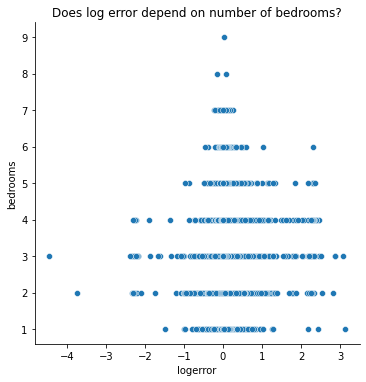

In [68]:
sns.relplot(
    y='bedrooms',
    x='logerror',
    data=train,
)
plt.title("Does log error depend on number of bedrooms?")

### Use Clustering to Identify Possible Features of Interest

In [69]:
# define independent variables for k-means

X = train[['bedrooms', 'bathrooms']]
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=3, random_state=321)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)

X_scaled['cluster'] = kmeans.predict(X_scaled)

In [70]:
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [71]:
# look at the head
X_scaled.head()

bedrooms  bathrooms
6378      0.250   0.000000
65133     0.375   0.222222
45602     0.250   0.222222
75623     0.375   0.222222
71792     0.375   0.222222

In [72]:
# lets look at sample of 15 randomly selected rows indataset

train.sample(15)

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips  \
44309        3.0       4.0                    6.0      1964.0  6059.0   
19934        2.5       3.0                    6.0      1452.0  6059.0   
68497        2.0       4.0                    4.0      1477.0  6037.0   
12858        2.5       3.0                    6.0      1936.0  6059.0   
9323         3.0       3.0                    8.0      1733.0  6037.0   
47329        3.0       3.0                    7.0      2305.0  6037.0   
15933        2.0       2.0                    8.0      1494.0  6037.0   
59946        2.0       4.0                    6.0      1864.0  6111.0   
2370         2.0       3.0                    6.0      1175.0  6037.0   
17123        2.0       3.0                    4.0      1234.0  6037.0   
52049        2.5       3.0                    6.0      1492.0  6059.0   
1222         3.0       2.0                    9.0      1488.0  6037.0   
56737        2.0       3.0                    6.0      1560.0  6037.0   
5714         1.0       2.0                    5.0       768.0  6037.0   
70453        2.0       2.0                    6.0      1076.0  6059.0   

         latitude    longitude  lotsizesquarefeet  propertylandusetypeid  \
44309  33638798.0 -117884458.0             1546.0                  261.0   
19934  33757395.0 -117827745.0             7313.0                  266.0   
68497  33813782.0 -118275496.0             7582.0                  261.0   
12858  33849930.0 -117739914.0             6480.0                  261.0   
9323   34414222.0 -118482891.0           453252.0                  266.0   
47329  34020633.0 -118101541.0             8420.0                  261.0   
15933  33724439.0 -118319222.0             7863.0                  261.0   
59946  34227256.0 -119044607.0             7528.0                  261.0   
2370   33836404.0 -118358997.0             5531.0                  261.0   
17123  34089485.0 -118001139.0             6057.0                  261.0   
52049  33730081.0 -117817029.0             1144.0                  261.0   
1222   34039400.0 -118457000.0             9894.0                  266.0   
56737  34051642.0 -118108676.0             5966.0                  261.0   
5714   34023666.0 -118164724.0             7960.0                  261.0   
70453  33687346.0 -117810672.0             7313.0                  266.0   

       rawcensustractandblock  ...  taxamount  logerror  transactiondate  \
44309            6.059063e+07  ...   10642.54  0.035643       2017-06-08   
19934            6.059076e+07  ...    1028.18 -0.006745       2017-03-24   
68497            6.037544e+07  ...    6041.40 -0.021093       2017-08-21   
12858            6.059022e+07  ...    4292.90  0.001205       2017-02-28   
9323             6.037920e+07  ...    5800.82  0.042570       2017-02-13   
47329            6.037530e+07  ...    7665.37 -0.027768       2017-06-16   
15933            6.037297e+07  ...    8176.42 -0.025652       2017-03-10   
59946            6.111006e+07  ...     875.68  0.169763       2017-07-25   
2370             6.037651e+07  ...    3576.24 -0.055222       2017-01-11   
17123            6.037433e+07  ...    6621.32  0.010841       2017-03-15   
52049            6.059076e+07  ...    2041.14  0.066973       2017-06-29   
1222             6.037268e+07  ...    4399.98 -0.012954       2017-01-06   
56737            6.037483e+07  ...    1242.57 -0.044637       2017-07-13   
5714             6.037532e+07  ...    1815.63  0.023649       2017-01-26   
70453            6.059053e+07  ...    2928.24 -0.058198       2017-08-25   

       heatingorsystemdesc        propertylandusedesc       county  \
44309                 None  Single Family Residential       Orange   
19934                  Yes                Condominium       Orange   
68497           Floor/Wall  Single Family Residential  Los Angeles   
12858                 None  Single Family Residential       Orange   
9323               Central                Condominium 

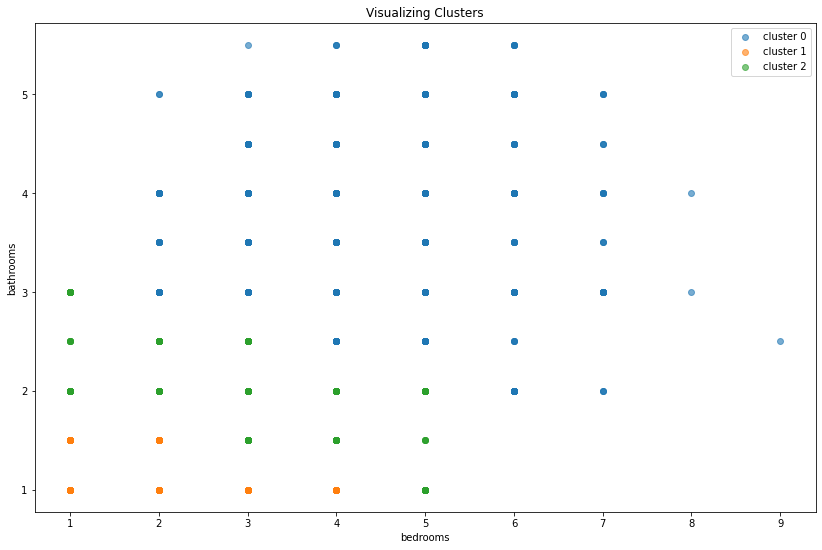

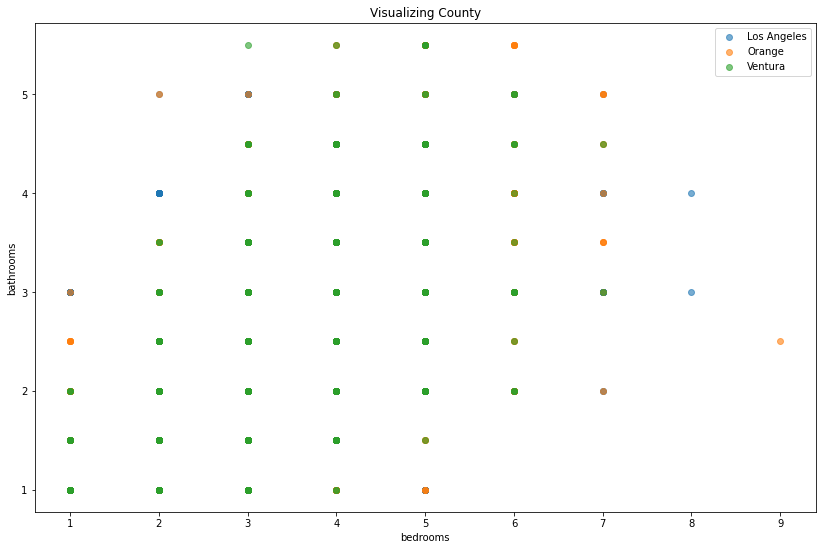

In [73]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.bedrooms, subset.bathrooms, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('bedrooms')
plt.ylabel('bathrooms')
plt.title('Visualizing Clusters')
plt.show()


plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('county'):
    plt.scatter(subset.bedrooms, subset.bathrooms, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('bedrooms')
plt.ylabel('bathrooms')
plt.title('Visualizing County')
plt.show()

In [74]:
# Bedrooms and bathrooms do not seem to cluster very well.  

In [75]:
#Try clustering by latitute and longitude

# define independent variables for k-means

X = train[['latitude','longitude']]
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=4, random_state=321)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)

X_scaled['cluster'] = kmeans.predict(X_scaled)

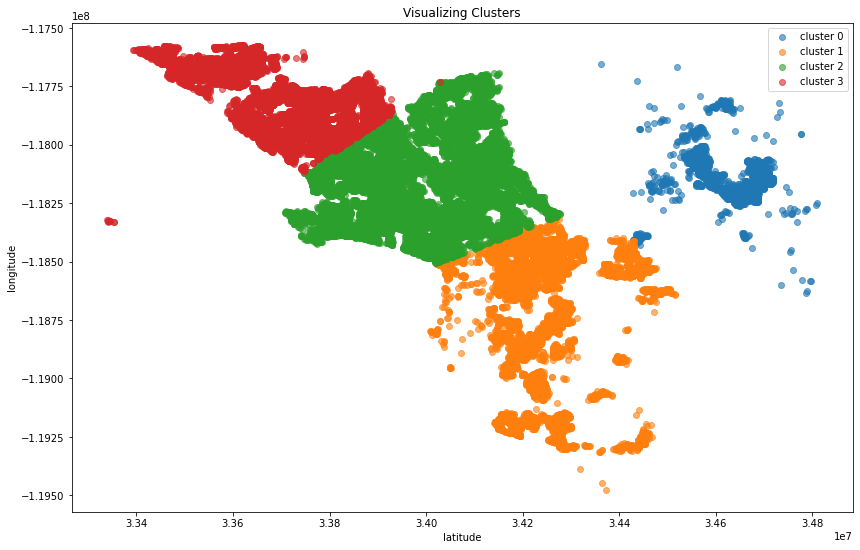

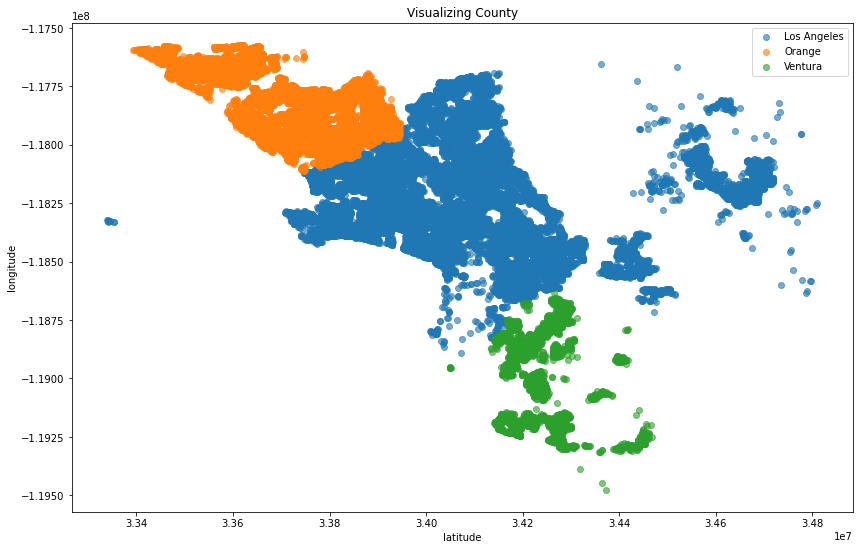

In [76]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Clusters')
plt.show()


plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('county'):
    plt.scatter(subset.latitude, subset.longitude, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing County')
plt.show()

Text(0.5, 1.0, 'Does log error depend on location?')

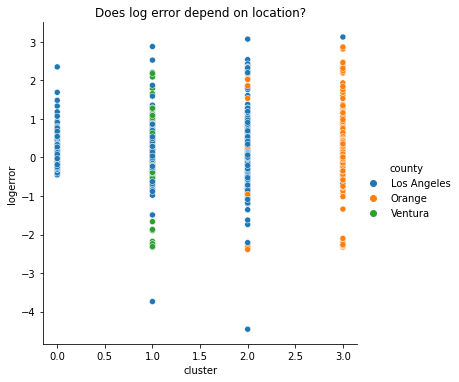

In [77]:
sns.relplot(
    x='cluster',
    y='logerror',
    data=train, hue='county'
)
plt.title("Does log error depend on location?")

In [78]:
#Latitude and longitude cluster well and match almost exactly with county id, but are not exactly the same.
#Clustering with 4 clusters seems to separate the regions better and may account for some of the log error that is
#found in properties near the coast.
#Los Angeles County is large and can be seen clustered with 4 out of the 4 regions, unlike the other two counties. 

Text(0.5, 1.0, 'Does county account for upper vs lower\n logerror by property type?')

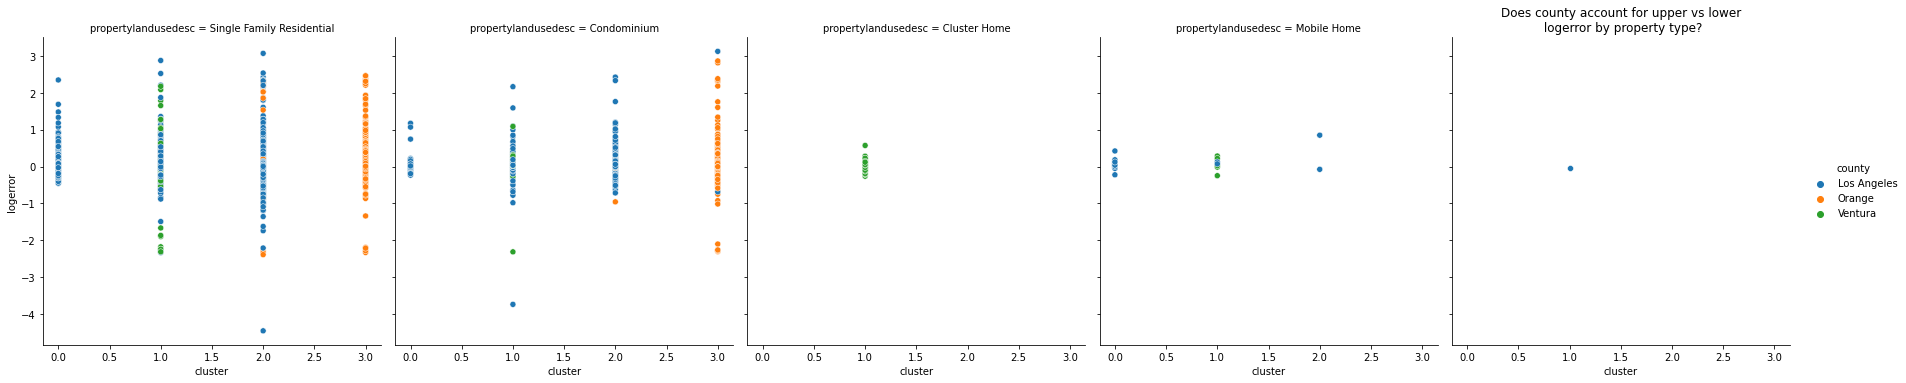

In [79]:
#Looking at logerror by county and property type
sns.relplot(
    x='cluster',
    y='logerror',
    data=train,
    hue='county',
    col='propertylandusedesc',
)
plt.title("Does county account for upper vs lower\n logerror by property type?")

Text(0.5, 1.0, 'Does county account for upper vs lower\n logerror by square footage?')

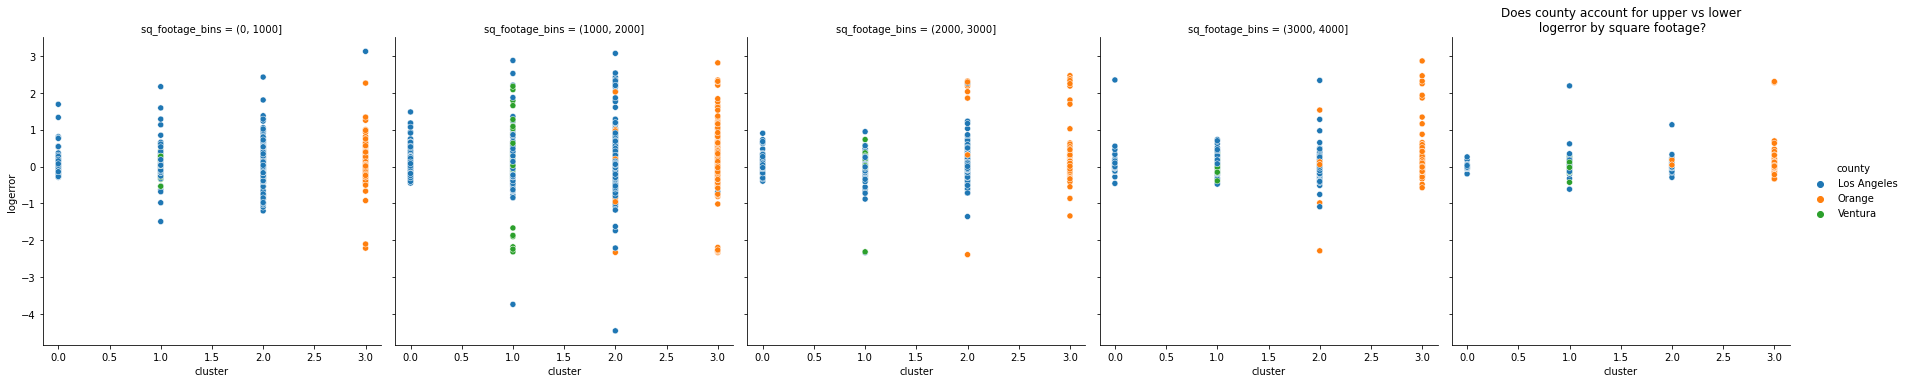

In [80]:
sns.relplot(
    x='cluster',
    y='logerror',
    data=train,
    hue='county',
    col='sq_footage_bins',
)
plt.title("Does county account for upper vs lower\n logerror by square footage?")

In [81]:
#Try different variables to find possible clusters

# define independent variables for k-means

X = train[['sq_footage','tax_value']]
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=5, random_state=321)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)

X_scaled['cluster'] = kmeans.predict(X_scaled)

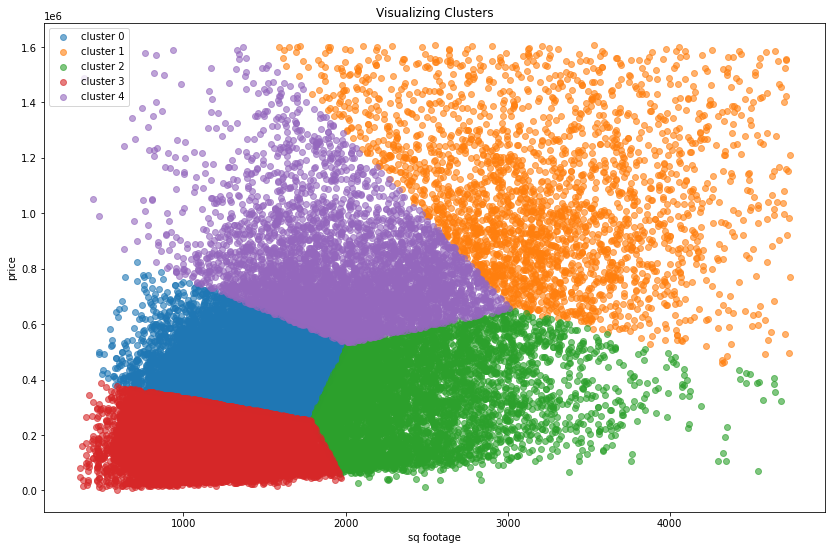

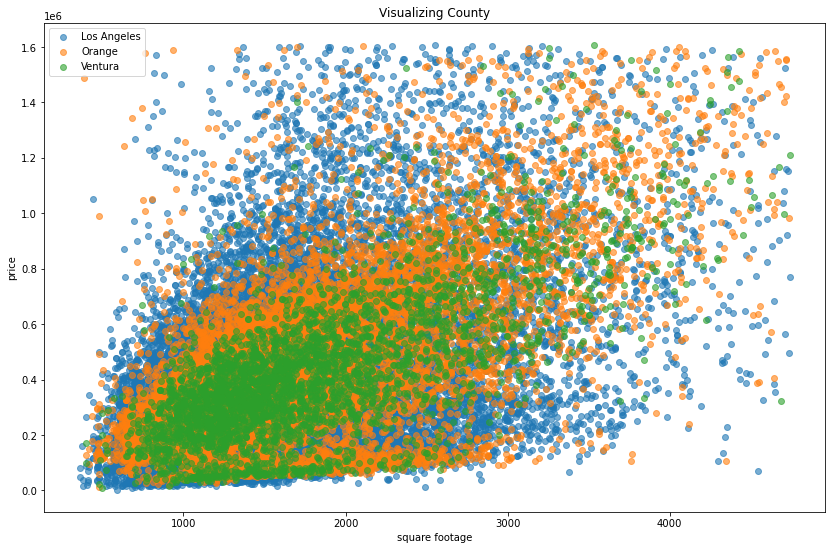

In [82]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.sq_footage, subset.tax_value, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('sq footage')
plt.ylabel('price')
plt.title('Visualizing Clusters')
plt.show()


plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('county'):
    plt.scatter(subset.sq_footage, subset.tax_value, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('square footage')
plt.ylabel('price')
plt.title('Visualizing County')
plt.show()

Text(0.5, 1.0, 'Does cluster account for upper vs lower\n logerror in the price?')

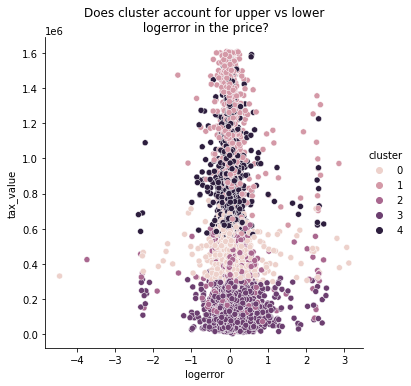

In [83]:
sns.relplot(
    y='tax_value',
    x='logerror',
    data=train,
    hue='cluster',
)
plt.title("Does cluster account for upper vs lower\n logerror in the price?")

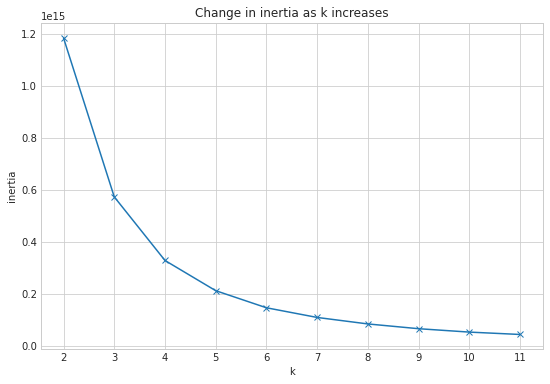

In [84]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [85]:
# Feature selection

In [86]:
train.columns

Index(['bathrooms', 'bedrooms', 'buildingqualitytypeid', 'sq_footage', 'fips',
       'latitude', 'longitude', 'lotsizesquarefeet', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yr_built',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'transactiondate',
       'heatingorsystemdesc', 'propertylandusedesc', 'county',
       'sq_footage_bins', 'month', 'month_bins', 'cluster'],
      dtype='object')

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40494 entries, 6378 to 40077
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   bathrooms                   40494 non-null  float64       
 1   bedrooms                    40494 non-null  float64       
 2   buildingqualitytypeid       40494 non-null  float64       
 3   sq_footage                  40494 non-null  float64       
 4   fips                        40494 non-null  float64       
 5   latitude                    40494 non-null  float64       
 6   longitude                   40494 non-null  float64       
 7   lotsizesquarefeet           40494 non-null  float64       
 8   propertylandusetypeid       40494 non-null  float64       
 9   rawcensustractandblock      40494 non-null  float64       
 10  regionidcity                40494 non-null  float64       
 11  regionidcounty              40494 non-null  float64

In [88]:
#Set up x and y to do feature comparison against log error
X_train = train.drop(columns=['logerror','transactiondate','heatingorsystemdesc','propertylandusedesc','county','sq_footage_bins','month_bins']) 

y_train = train.logerror


In [89]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=1)
rfe.fit(X_train, y_train)
rfe.get_support()

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [90]:
X_train.columns[rfe.get_support()]

Index(['bedrooms'], dtype='object')

In [91]:
pd.Series(rfe.ranking_, index=X_train.columns)

bathrooms                      2
bedrooms                       1
buildingqualitytypeid          3
sq_footage                     9
fips                           7
latitude                      22
longitude                     23
lotsizesquarefeet             15
propertylandusetypeid          5
rawcensustractandblock        13
regionidcity                  19
regionidcounty                12
regionidzip                   14
roomcnt                        6
unitcnt                       20
yr_built                      10
structuretaxvaluedollarcnt    17
tax_value                     16
assessmentyear                21
landtaxvaluedollarcnt         18
taxamount                     11
month                          8
cluster                        4
dtype: int64

In [92]:
# Bedrooms, Bathrooms, and Building Quality Type ID were the top 3 features identified with the Select K Best feature selection.
# Make sure to include those in my model.

In [104]:
#Try different variables again to find possible clusters

# define independent variables for k-means

X = train[['regionidcity','regionidzip']]
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=5, random_state=321)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)

X_scaled['cluster'] = kmeans.predict(X_scaled)

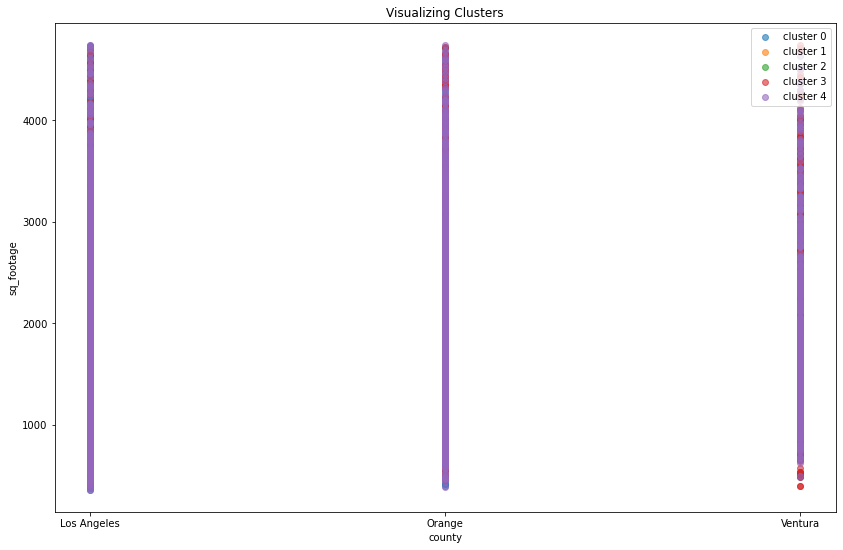

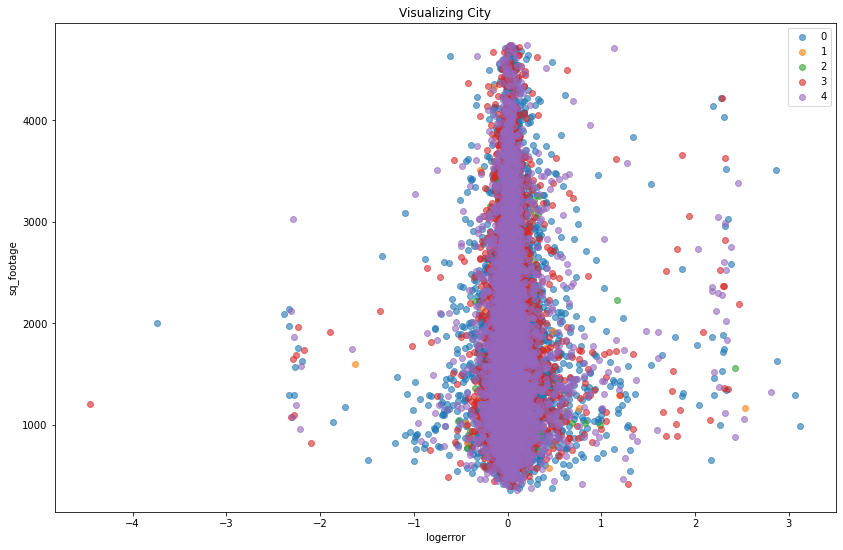

In [110]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.county, subset.sq_footage, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('county')
plt.ylabel('sq_footage')
plt.title('Visualizing Clusters')
plt.show()


plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.logerror, subset.sq_footage, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('logerror')
plt.ylabel('sq_footage')
plt.title('Visualizing City')
plt.show()

In [95]:
# Regionidcity and regionidzip are not very helpful in clustering

In [96]:
# Create a new feature to see if clustering is possible by this new feature

In [112]:
# Creating more features to repeat clustering with
# Feature Engineering
train['bed_bath_count'] = train.bedrooms + train.bathrooms



conditions = [
    (train['month'] == 12) | (train['month'] <= 2),
    (train['month'] == 3) | (train['month'] == 4) | (train['month'] == 5),
    (train['month'] == 6) | (train['month'] == 7) | (train['month'] == 8),
    (train['month'] == 9) | (train['month'] == 10) | (train['month'] == 11)
    ]

values = ['winter', 'spring', 'summer', 'fall']

train['season'] = np.select(conditions, values)
train.head()

bathrooms  bedrooms  buildingqualitytypeid  sq_footage    fips  \
6378         1.0       3.0                    4.0      1368.0  6037.0   
65133        2.0       4.0                    8.0      2381.0  6037.0   
45602        2.0       3.0                    6.0      1810.0  6037.0   
75623        2.0       4.0                    6.0      1558.0  6059.0   
71792        2.0       4.0                    6.0      1769.0  6111.0   

         latitude    longitude  lotsizesquarefeet  propertylandusetypeid  \
6378   34174813.0 -118512540.0             5899.0                  261.0   
65133  34536607.0 -118049605.0            39349.0                  261.0   
45602  33824560.0 -118270268.0             5604.0                  261.0   
75623  33791770.0 -118068568.0             8255.0                  261.0   
71792  34265339.0 -118798087.0             8090.0                  261.0   

       rawcensustractandblock  ...  transactiondate  heatingorsystemdesc  \
6378             6.037139e+07  ...       2017-01-30           Floor/Wall   
65133            6.037911e+07  ...       2017-08-10              Central   
45602            6.037544e+07  ...       2017-06-13           Floor/Wall   
75623            6.059110e+07  ...       2017-09-12                 None   
71792            6.111008e+07  ...       2017-08-30                 None   

             propertylandusedesc       county  sq_footage_bins  month  \
6378   Single Family Residential  Los Angeles     (1000, 2000]      1   
65133  Single Family Residential  Los Angeles     (2000, 3000]      8   
45602  Single Family Residential  Los Angeles     (1000, 2000]      6   
75623  Single Family Residential       Orange     (1000, 2000]      9   
71792  Single Family Residential      Ventura     (1000, 2000]      8   

       month_bins  cluster  bed_bath_count  season  
6378       (0, 3]        0             4.0  winter  
65133      (6, 9]        4             6.0  summer  
45602      (3, 6]        0             5.0  summer  
75623      (6, 9]        4             6.0    fall  
71792      (6, 9]        3             6.0  summer  

[5 rows x 32 columns]

In [120]:
#Try different variables again to find possible clusters

# define independent variables for k-means

X = train[['latitude','longitude']]
scaler = MinMaxScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])
# sklearn implementation of KMeans

#define the thing
kmeans = KMeans(n_clusters=5, random_state=321)

# fit the thing
kmeans.fit(X_scaled)

# Use (predict using) the thing 
kmeans.predict(X_scaled)
train['cluster'] = kmeans.predict(X_scaled)

X_scaled['cluster'] = kmeans.predict(X_scaled)

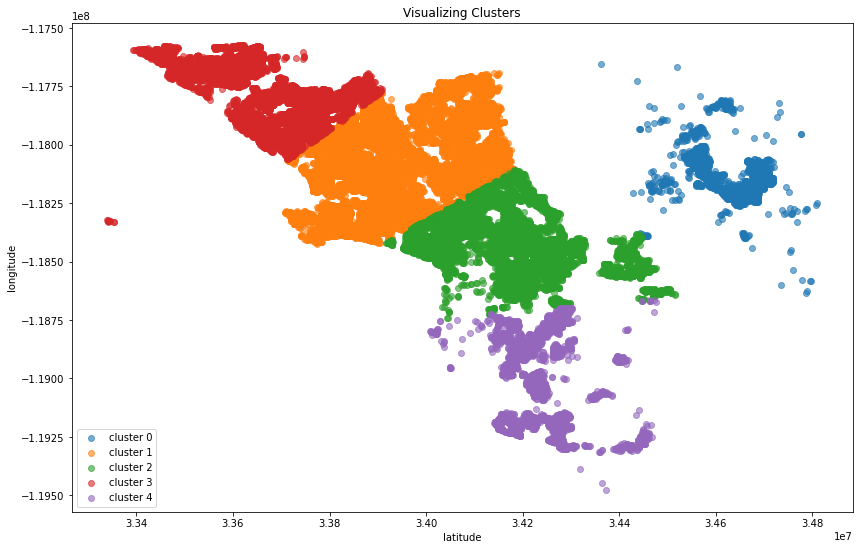

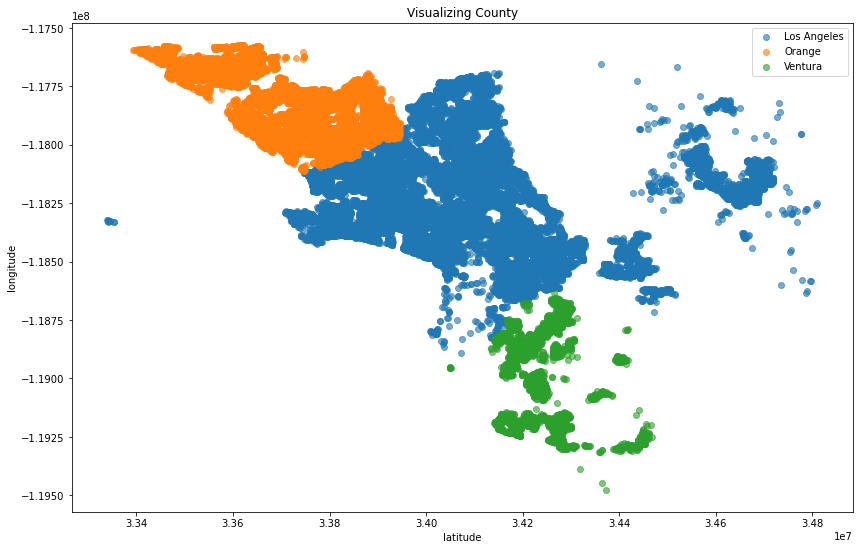

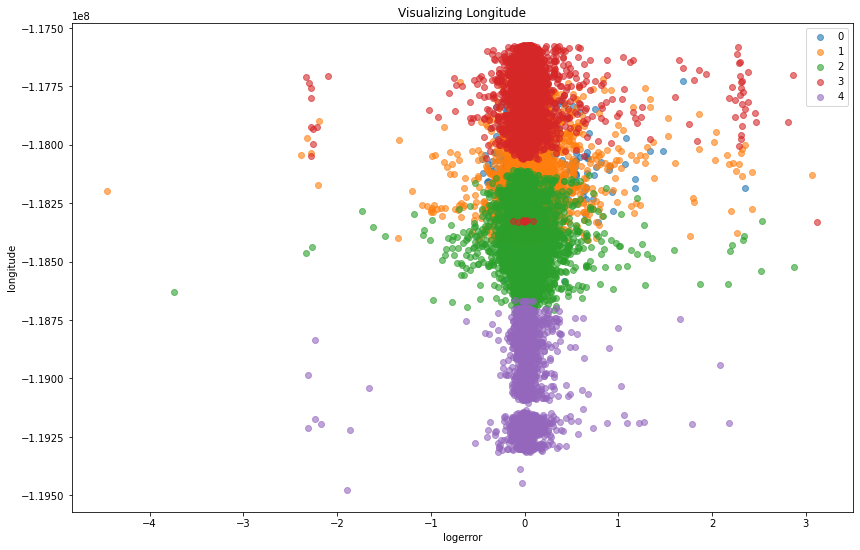

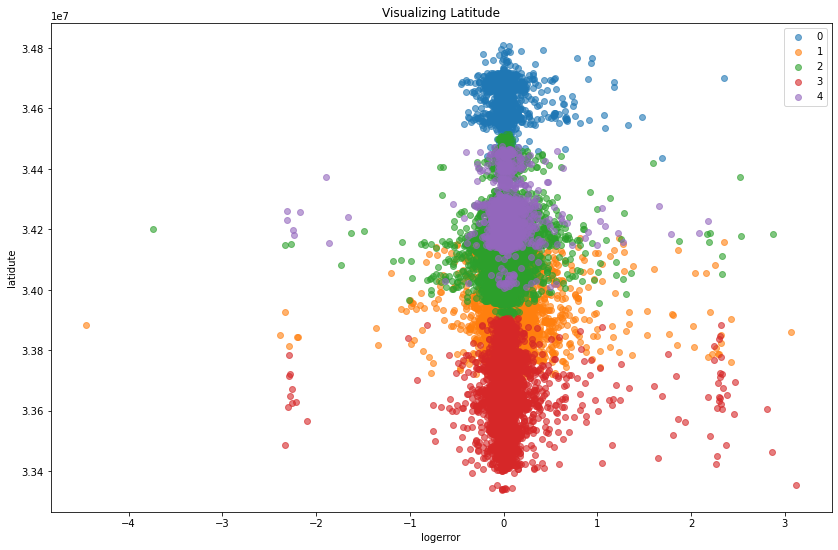

In [123]:
plt.figure(figsize=(14, 9))

for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6, cmap='reds')
plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing Clusters')
plt.show()

plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('county'):
    plt.scatter(subset.latitude, subset.longitude, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing County')
plt.show()


plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.logerror, subset.longitude, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('logerror')
plt.ylabel('longitude')
plt.title('Visualizing Longitude')
plt.show()


plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('cluster'):
    plt.scatter(subset.logerror, subset.latitude, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('logerror')
plt.ylabel('latidute')
plt.title('Visualizing Latitude')
plt.show()

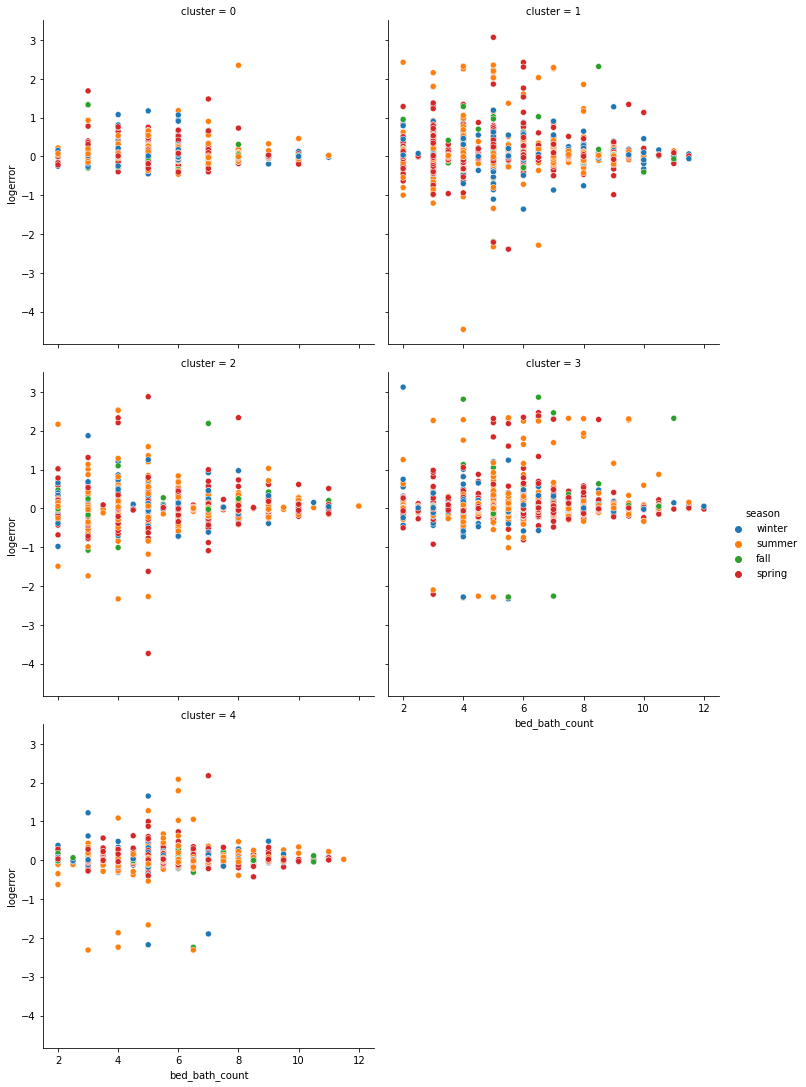

In [124]:
# visualize w/ hue="season" style="cluster"
sns.relplot(x="bed_bath_count", y="logerror", hue="season", col="cluster",  col_wrap=2,data=train)

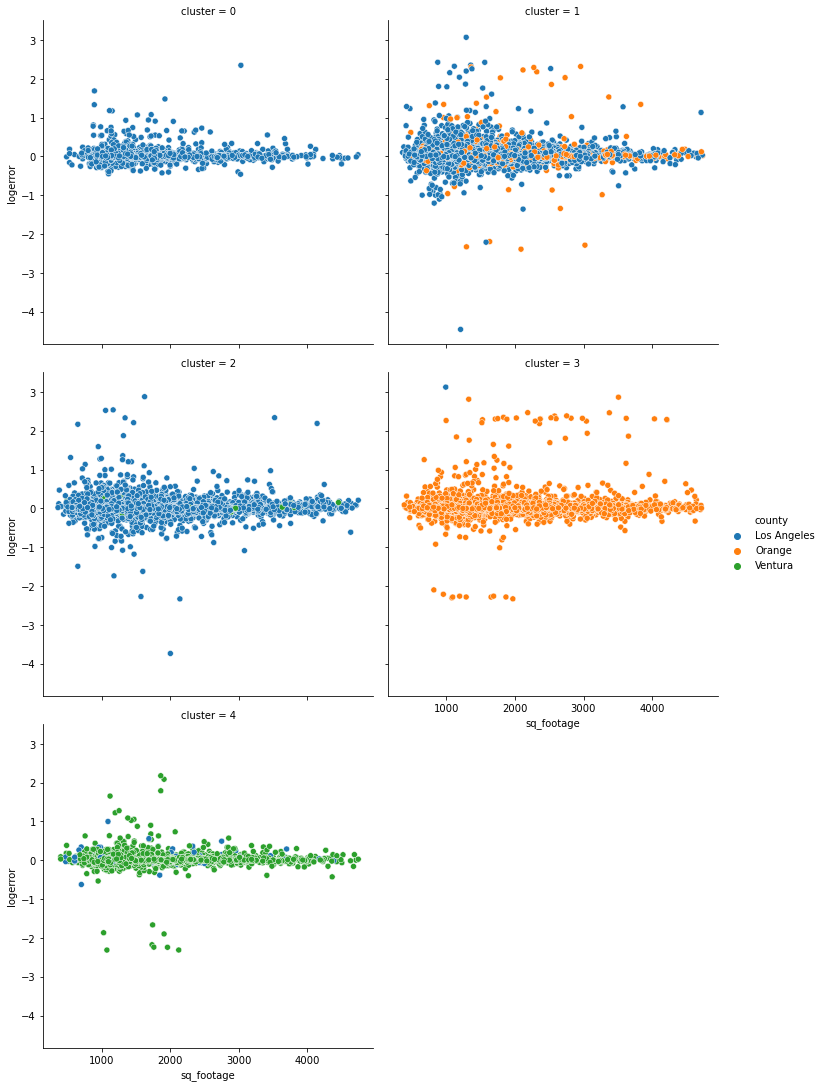

In [125]:
# visualize w/ hue="season" style="cluster"
sns.relplot(x="sq_footage", y="logerror", hue="county", col="cluster",  col_wrap=2,data=train)

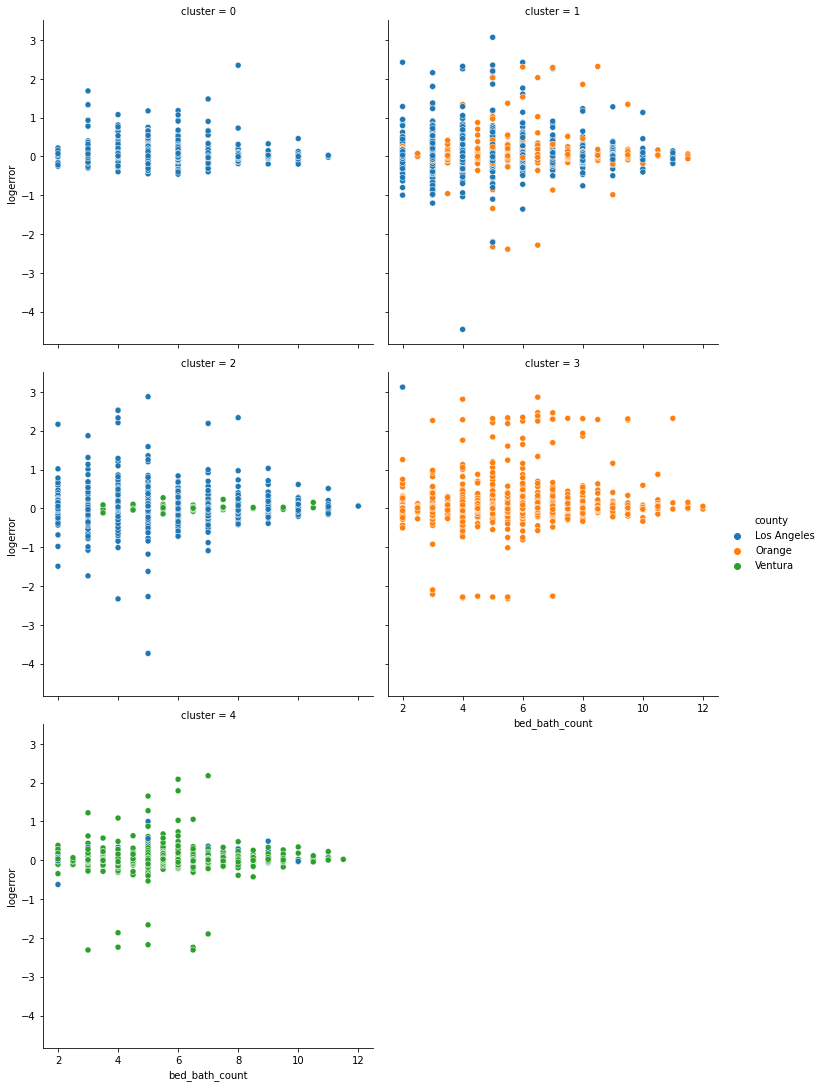

In [126]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="bed_bath_count", y="logerror", hue="county", col="cluster",  col_wrap=2,data=train)

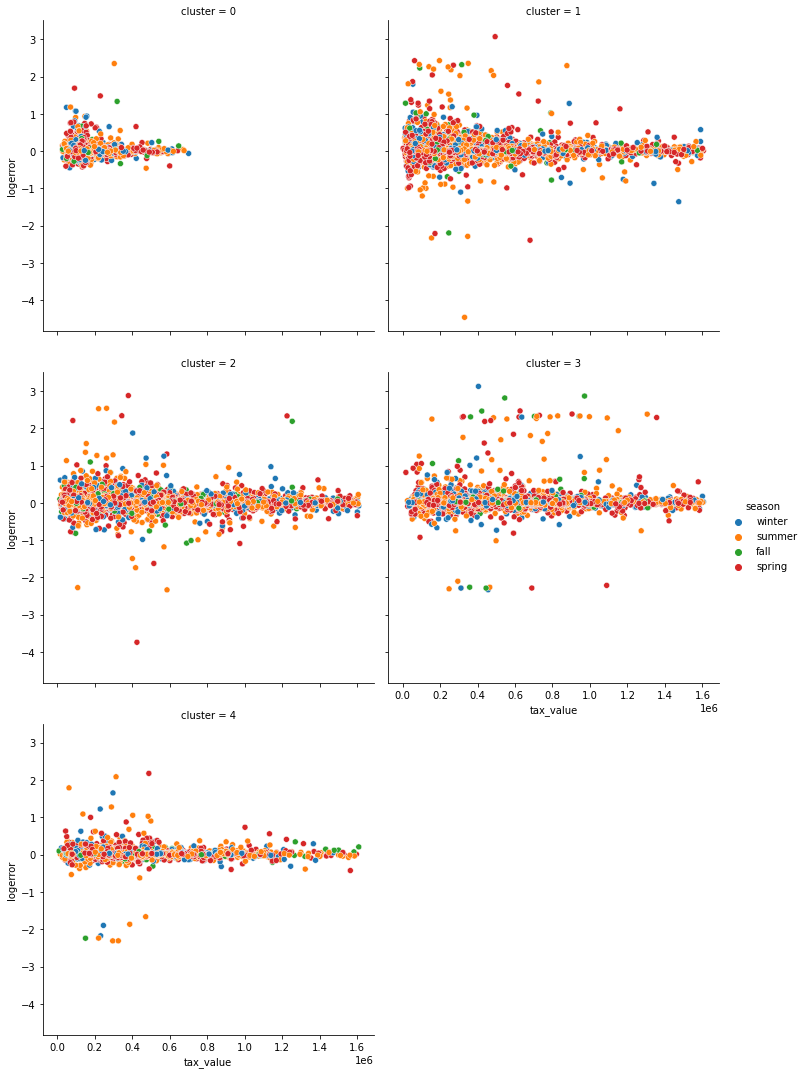

In [130]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="tax_value", y="logerror", hue="season", col="cluster",  col_wrap=2,data=train)

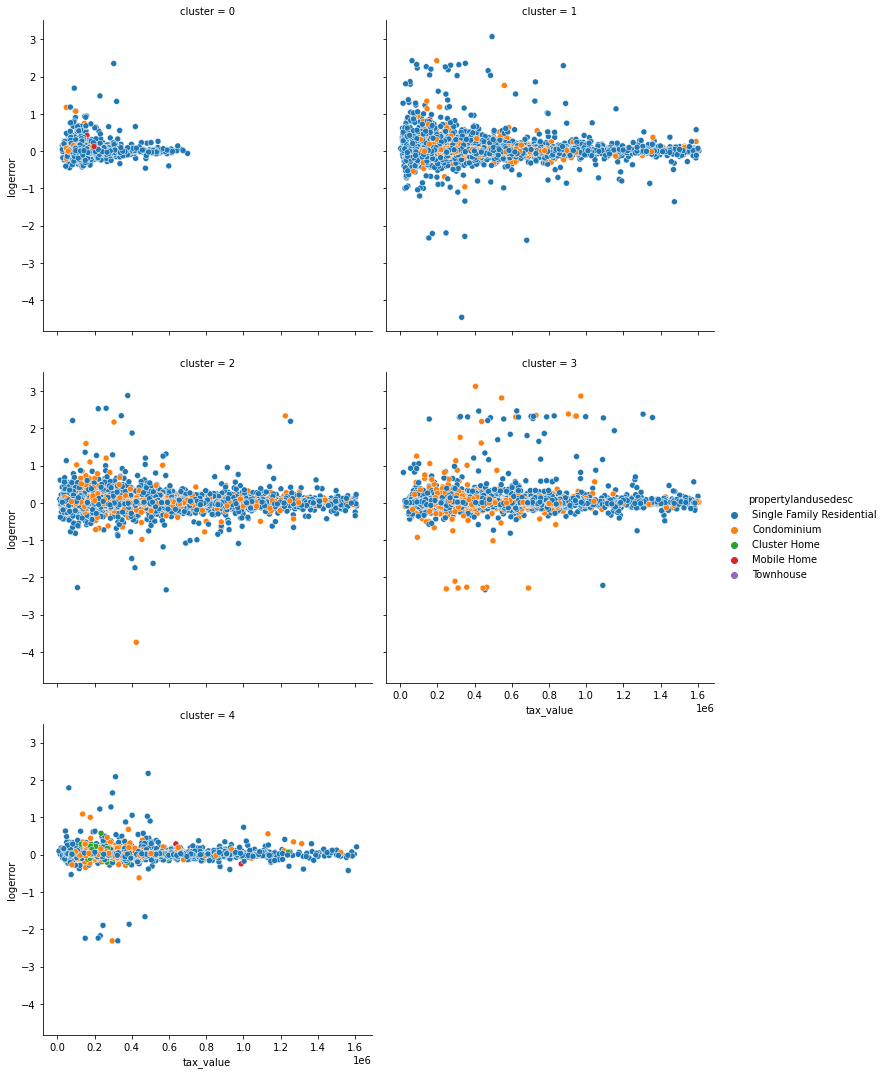

In [131]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="tax_value", y="logerror", hue="propertylandusedesc", col="cluster",  col_wrap=2,data=train)

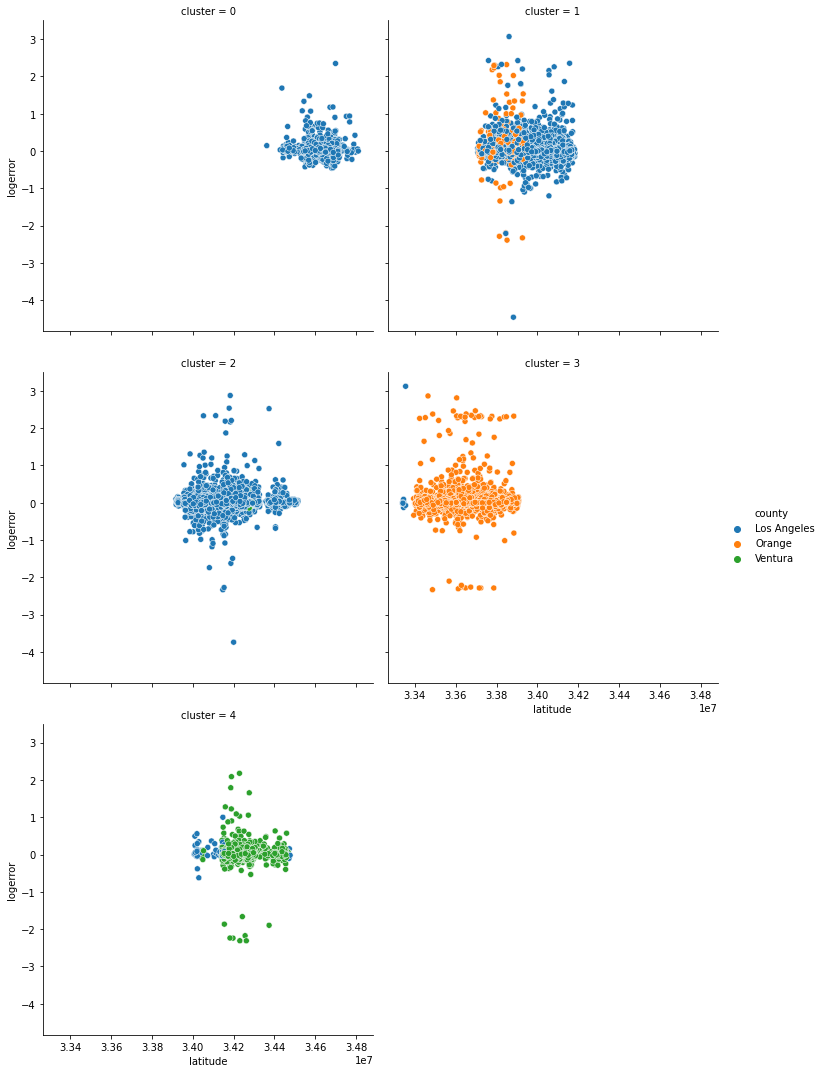

In [133]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="latitude", y="logerror", hue="county", col="cluster",  col_wrap=2,data=train)

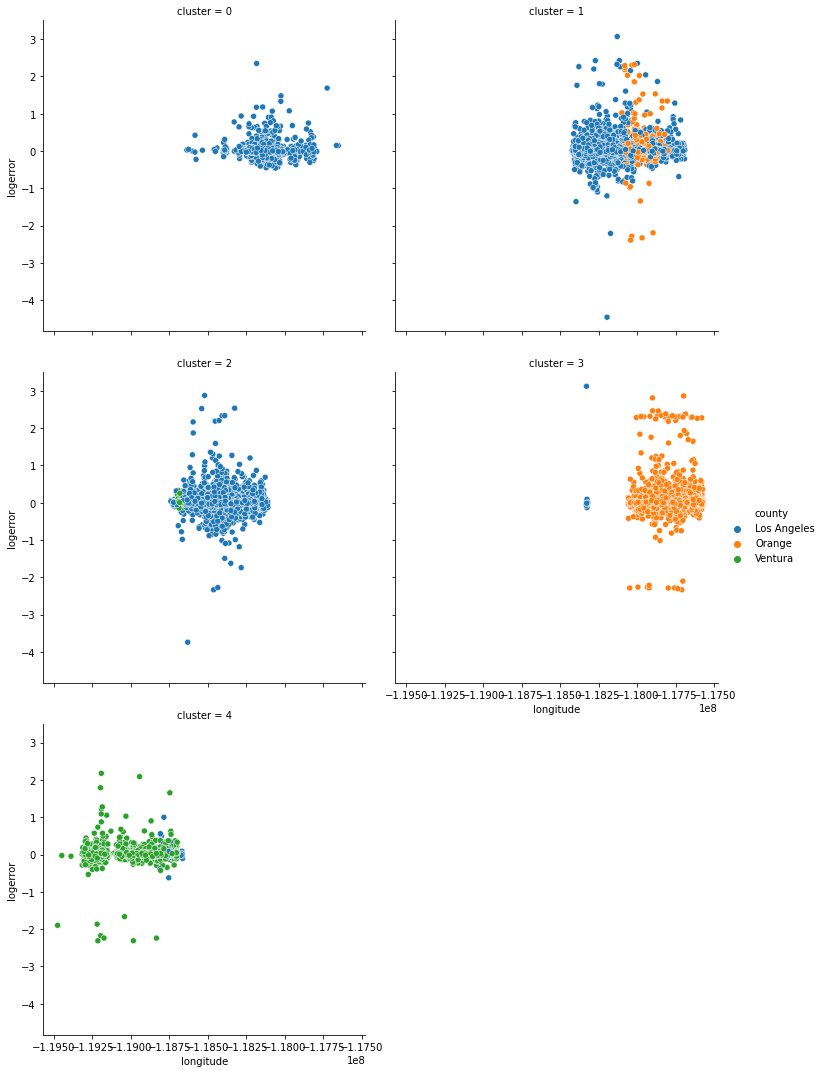

In [140]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="longitude", y="logerror", hue="county", col="cluster",  col_wrap=2, data=train)

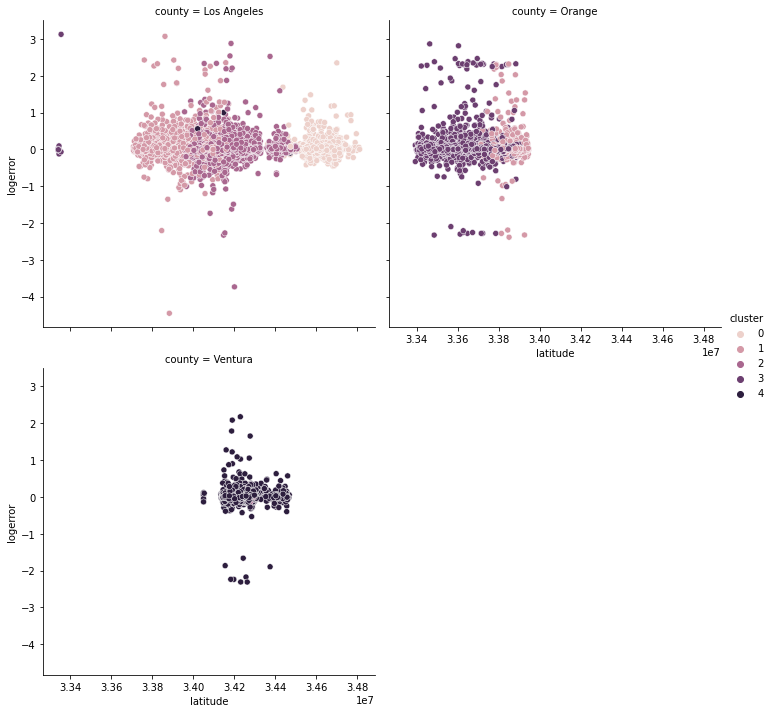

In [135]:
# visualize w/ hue="season" style="cluster"
sns.relplot(x="latitude", y="logerror", hue="cluster", col="county",  col_wrap=2,data=train)

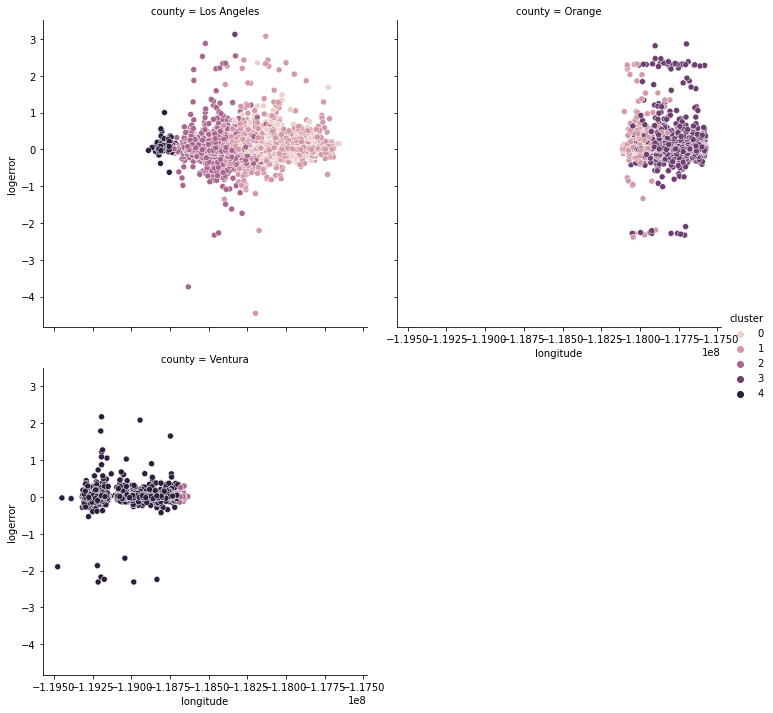

In [136]:
# visualize w/ hue="season" style="cluster"
sns.relplot(x="longitude", y="logerror", hue="cluster", col="county",  col_wrap=2,data=train)

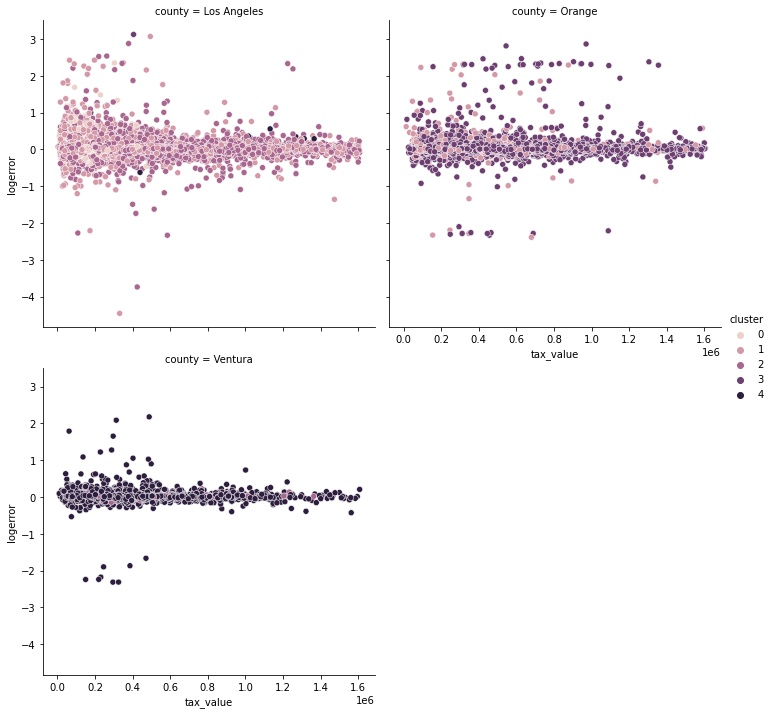

In [141]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="tax_value", y="logerror", hue="cluster", col="county",  col_wrap=2,data=train)

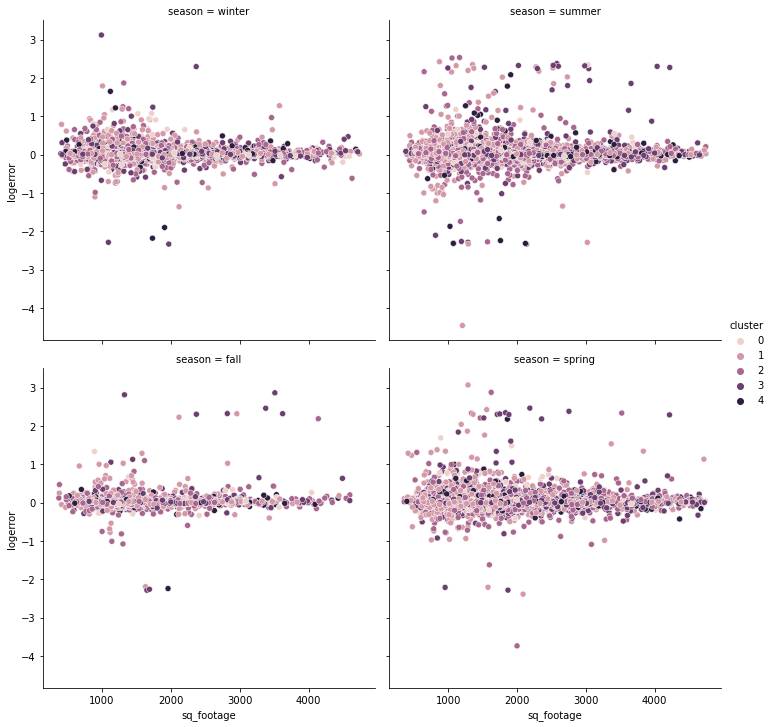

In [146]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="sq_footage", y="logerror", hue="cluster", col="season",  col_wrap=2,data=train)

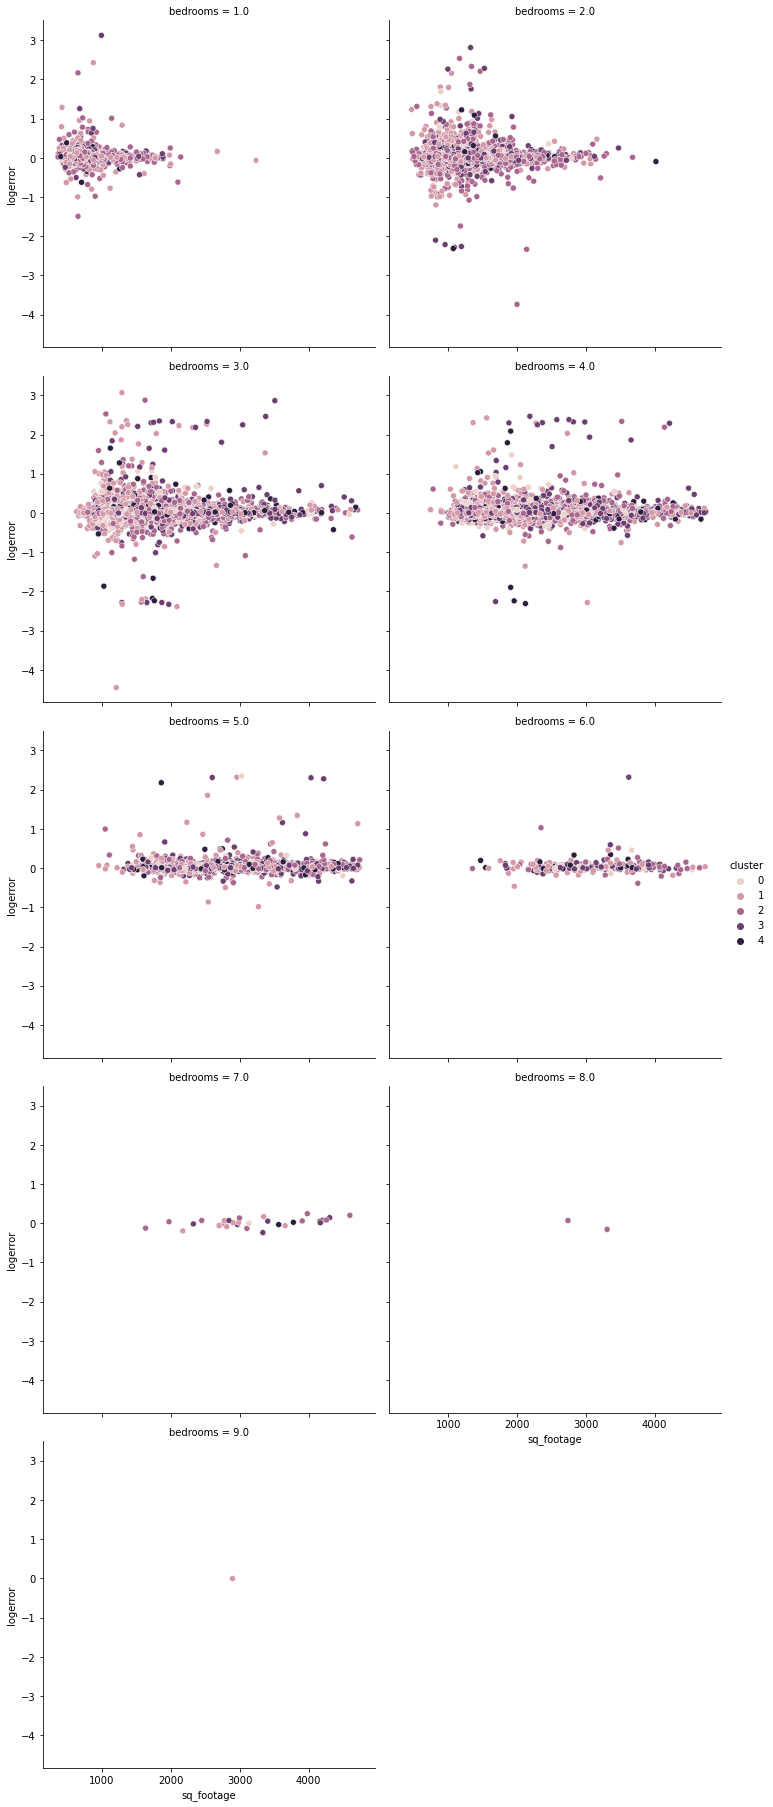

In [147]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="sq_footage", y="logerror", hue="cluster", col="bedrooms",  col_wrap=2,data=train)

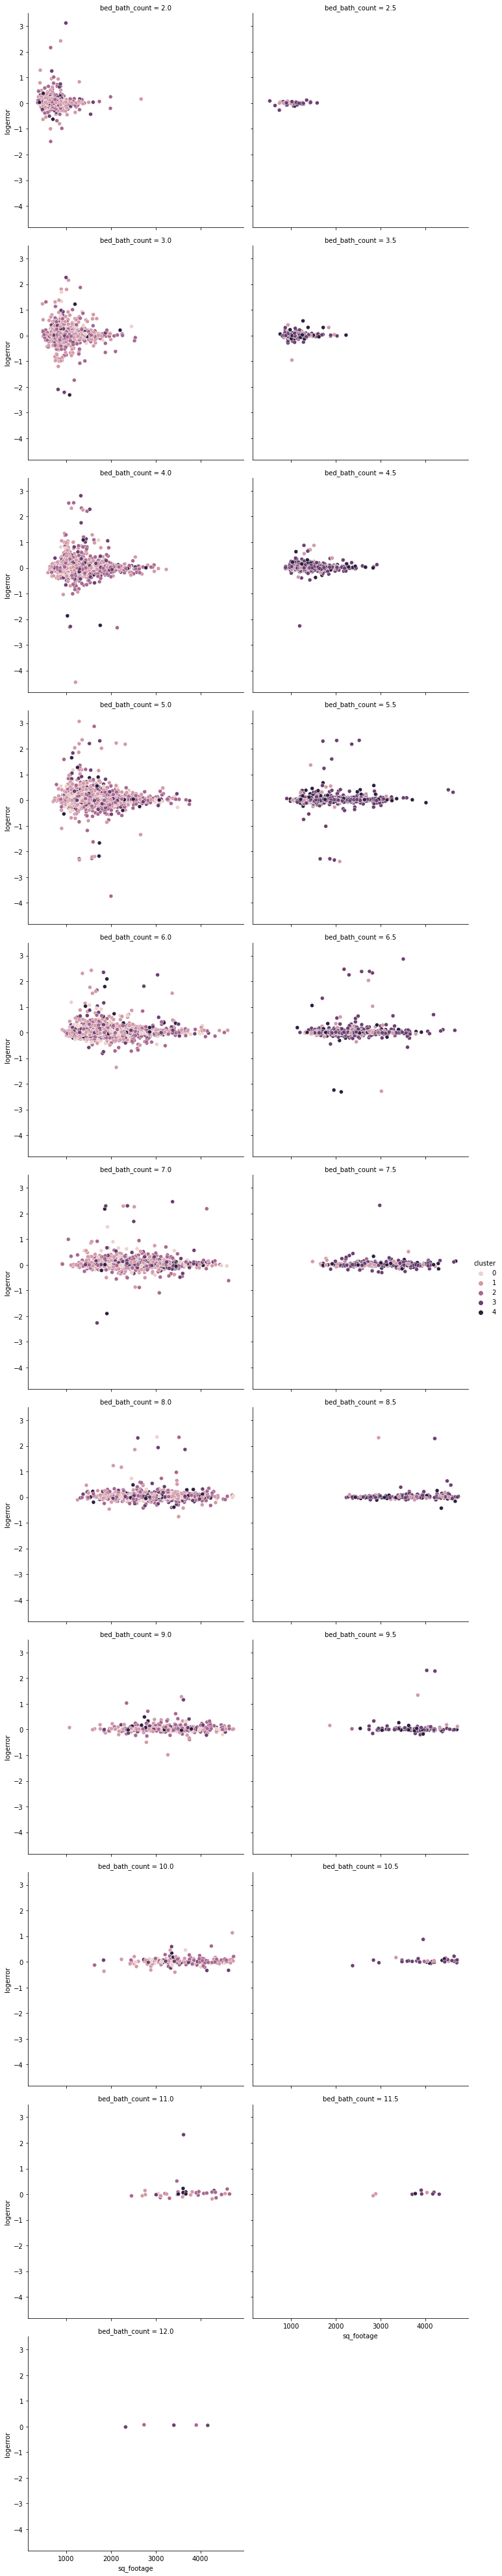

In [154]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="sq_footage", y="logerror", hue="cluster", col="bed_bath_count",  col_wrap=2,data=train)

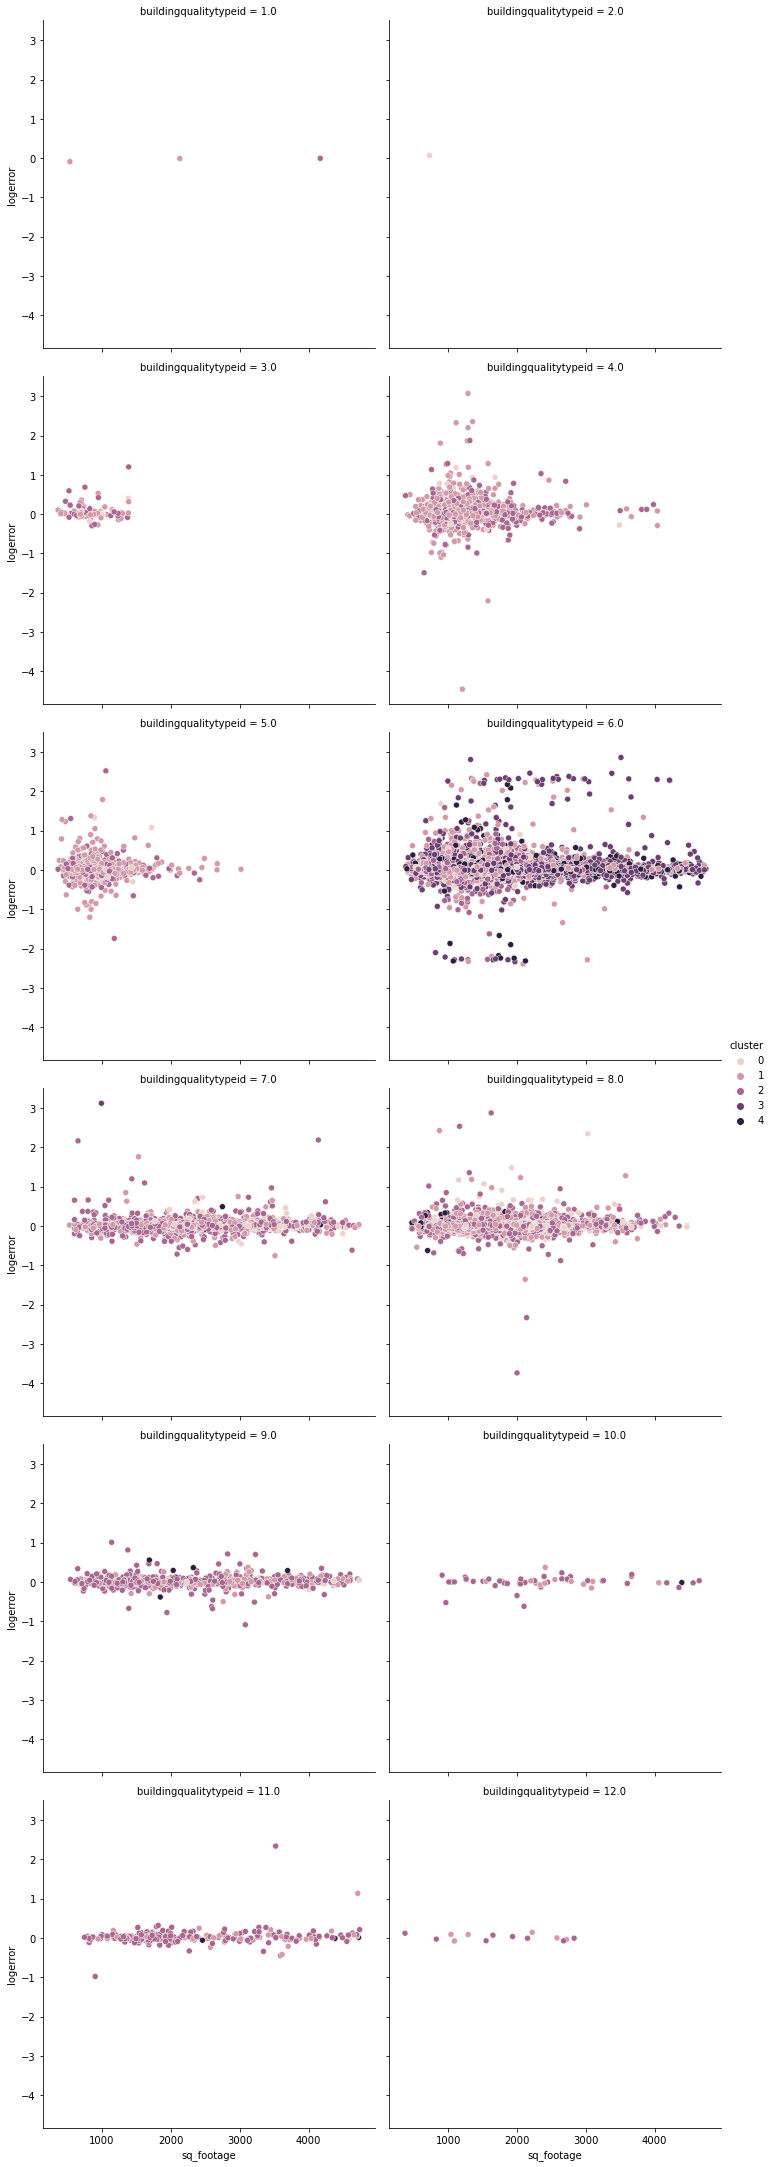

In [149]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="sq_footage", y="logerror", hue="cluster", col="buildingqualitytypeid",  col_wrap=2,data=train)

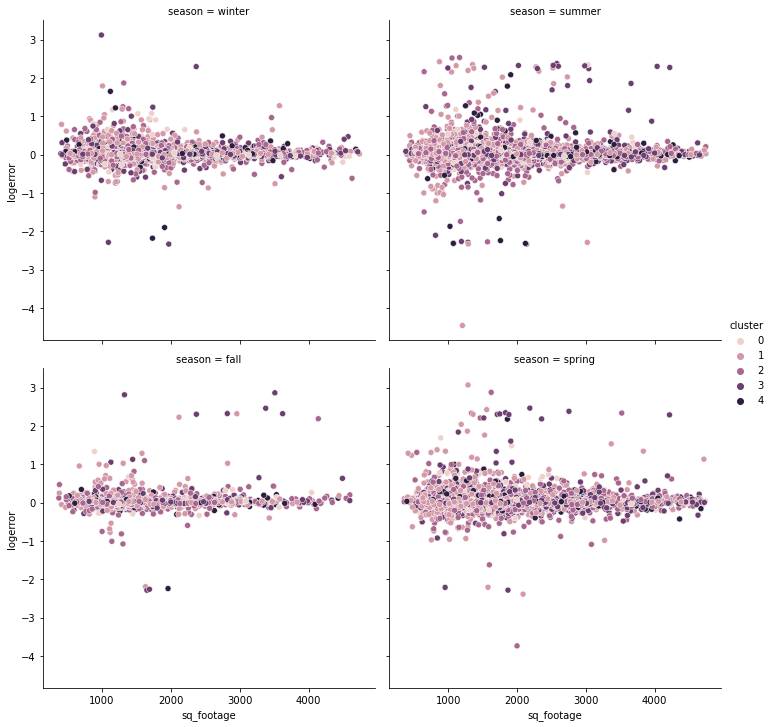

In [153]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="sq_footage", y="logerror", hue="cluster", col="season",  col_wrap=2,data=train)

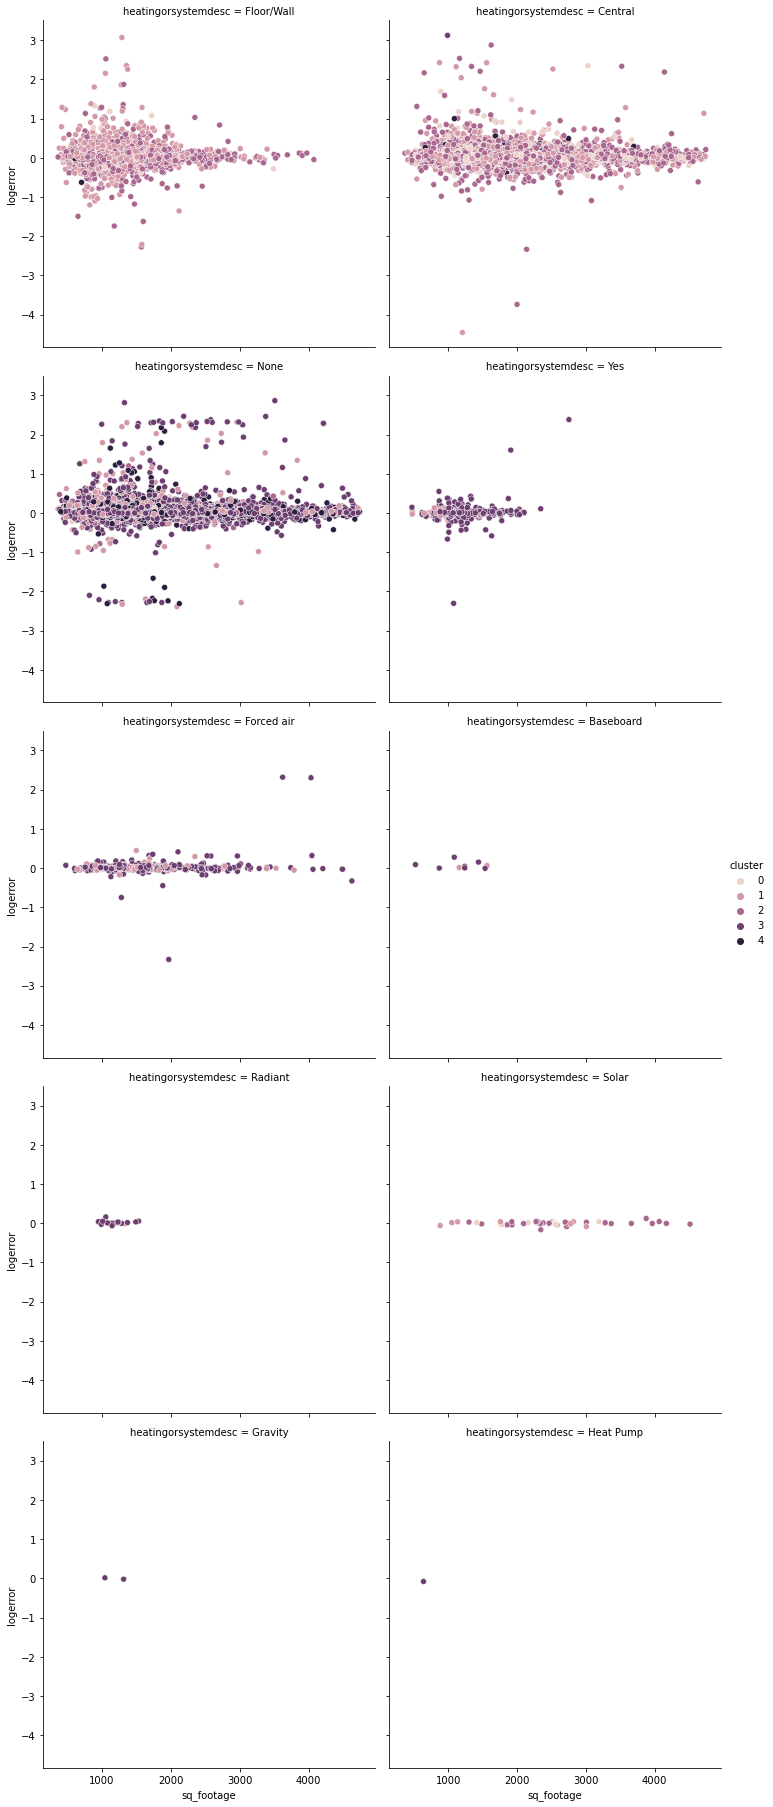

In [156]:
# visualize w/ hue="county" style="cluster"
sns.relplot(x="sq_footage", y="logerror", hue="cluster", col="heatingorsystemdesc",  col_wrap=2,data=train)

### Takeaways of Exploration

All 4 null hypothesis with square footage, number of bedrooms, number of bathrooms and property type not being correlated to price were rejected

In looking at the visualizations, there is a clear relationship between price features

As number of bedrooms, square footage, and bathrooms goes up, so does price

Property type does affect price, whether townhome vs mobile home vs single family residential


TO DO NEXT:
    
    - Based on visual findings, come up with a list of drivers
    - Come up with hypothesis testing to confirm dependency and correlation
    
    -Create a baseline of log error
    -Create 4 models to compare against using features found in exploration.
    

# Modeling

Look at the Target Variable/y

This helps us determine which type of algorithm we may want to use.

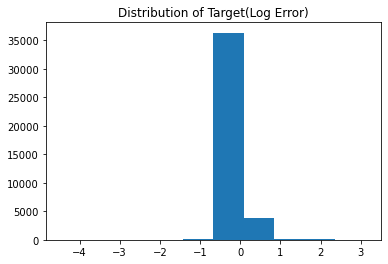

In [99]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target(Log Error)')
plt.show()

In [100]:
len(y_train)

40494

In [101]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)
y_train.head()

NameError: name 'y_validate' is not defined

In [ ]:
y_validate.head()


### Baseline
About the initial baseline:

Before we begin making models, we need to know how well we can estimate (predict) the final error (logerror) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every error to be the mean error of all the properties in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat.

Predict all errors to be , which is equal to the mean of logerror for the training sample. Store in y_train['logerror_mean'].

Predict all final errors to be , which is equal to the median of logerror for the training sample. Store in y_train['logerror_median'].

Compute the RMSE comparing actual final error (logerror) to logerror_mean.
Compute the RMSE comparing actual final error (logerror) to logerror_median.

In [ ]:
# 1. Predict logerror_mean
logerror_mean = y_train.logerror.mean()
y_train['logerror'] = logerror_mean
#y_validate['price_pred_mean'] = price_pred_mean


# Modeling Takeaways:

Polynomial Regression Model performed better than the baseline by having a lower RMSE than the baseline
The model had a difference of over $60,000 compared to the baseline
The model explained 35.6% of the variance on out of sample data very similar to our validate dataset.